In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import sys
import importlib
import pandas as pd
from matplotlib.colors import ListedColormap


from utils_orbs.orb_paths import SetupPaths
import utils_orbs.readsubfHDF5Py3 as readSub
# from utils.read_group_cats import ReadCats
from utils_orbs.merger_trees import TraceMergerTree
from utils_orbs.readMergerHistoryFiles import FindHistory
from utils_orbs.vectorCorrection import vectorCorrection as vector

paths = SetupPaths()

imported h5py...
modules seem to have loaded?


In [2]:
plt.show();
plt.rcParams.update({'font.size':20,"xtick.direction":"in","ytick.direction":"in", 
                     "xtick.top":True, "ytick.right":True,"text.usetex":False,
                     "xtick.labelsize":18,"ytick.labelsize":18,
                     "xtick.minor.top":True, "ytick.minor.right":True,
                     "xtick.minor.visible": True,
                     "ytick.minor.visible": True})

In [3]:
# defining color palette for plotting
palette = {"low":"olive", "high":"salmon", 
           "difference":"#2C1D11", "difference2":"#464646"
          }    
        

## Make colormaps!

In [4]:
N = 256
half = 128
third = 85
quarter = 64

# 
gr, gg, gb = [128/256, 128/256, 38/256]
pr, pg, pb = [234/256, 134/256, 119/256]

vals = np.ones((N, 4))
vals[:, 0] = np.linspace(1, gr, N)
vals[:, 1] = np.linspace(1, gg, N)
vals[:, 2] = np.linspace(1, gb, N)
green_map = ListedColormap(vals)

vals = np.ones((N, 4))
vals[:, 0] = np.concatenate( (np.linspace(1, gr, third), np.linspace(gr, 0, N-third)) )
vals[:, 1] = np.concatenate( (np.linspace(1, gg, third), np.linspace(gg, 0, N-third)) )
vals[:, 2] = np.concatenate( (np.linspace(1, gb, third), np.linspace(gb, 0, N-third)) )
dark_green = ListedColormap(vals)

vals = np.ones((N, 4))
vals[:, 0] = np.concatenate( (np.linspace(1, gr, quarter), np.linspace(gr, 0, N-quarter)) )
vals[:, 1] = np.concatenate( (np.linspace(1, gg, quarter), np.linspace(gg, 0, N-quarter)) )
vals[:, 2] = np.concatenate( (np.linspace(1, gb, quarter), np.linspace(gb, 0, N-quarter)) )
darkest_green = ListedColormap(vals)

vals = np.ones((N, 4))
vals[:, 0] = np.linspace(1, pr, N)
vals[:, 1] = np.linspace(1, pg, N)
vals[:, 2] = np.linspace(1, pb, N)
pink_map = ListedColormap(vals)

vals = np.ones((N, 4))
vals[:, 0] = np.concatenate( (np.linspace(1, pr, third), np.linspace(pr, 0, N-third)) )
vals[:, 1] = np.concatenate( (np.linspace(1, pg, third), np.linspace(pg, 0, N-third)) )
vals[:, 2] = np.concatenate( (np.linspace(1, pb, third), np.linspace(pb, 0, N-third)) )
dark_pink = ListedColormap(vals)

vals = np.ones((N, 4))
vals[:, 0] = np.concatenate( (np.linspace(1, pr, quarter), np.linspace(pr, 0, N-quarter)) )
vals[:, 1] = np.concatenate( (np.linspace(1, pg, quarter), np.linspace(pg, 0, N-quarter)) )
vals[:, 2] = np.concatenate( (np.linspace(1, pb, quarter), np.linspace(pb, 0, N-quarter)) )
darkest_pink = ListedColormap(vals)


# Import data

In [4]:
high,low = {}, {}
for i in [33,40,50]:
    high[i] = {}
    f = h5py.File(f"{paths.path_data}big-bad/massive_orbitdata_{i}.hdf5",'r')
    for key, val in f.items():
        high[i][key] = np.array(val)
    f.close()
    
    low[i] = {}
    f = h5py.File(f"{paths.path_data}hail-mary/orbitdata_{i}.hdf5",'r')
    for key, val in f.items():
        low[i][key] = np.array(val)
    f.close()



In [5]:
low_all = {}
f = h5py.File(f"{paths.path_data}hail-mary/unique_orbits.hdf5",'r')
for key, val in f.items():
    low_all[key] = np.array(val)
f.close()

high_all = {}
f = h5py.File(f"{paths.path_data}big-bad/unique_orbits_massive.hdf5",'r')
for key, val in f.items():
    high_all[key] = np.array(val)
f.close()

f = h5py.File(f"{paths.path_data}snapshot_data.hdf5",'r')
convert = {}
for key, val in f.items():
    convert[key] = np.array(val)
f.close()

## Add PostInfall flag

In [6]:
# let's try to be smart about this ~ 
infall = np.array(np.triu(np.zeros((100,100))+1),dtype='bool')

for dat in [low[33], low[40], low[50], low_all, high[33], high[40], high[50], high_all]:
    dat["PostInfall"] = infall[dat['InfallSnapshot']]


## Create interpolated data for low_all and high_all

In [8]:
def create_interp(data, convert, num_samples=10000):
    # first, create interpolated conversion file so I have a list of redshifts and lookback times
    convert_interp = {}
    convert_interp["Lookback Time Interp"] = np.linspace(convert['Lookback Time'][0],convert['Lookback Time'][-1],num_samples)

    # interpolating Redshift along with Lookback Time:
    convert_interp["Redshift Interp"] = np.interp(convert_interp["Lookback Time Interp"][::-1], xp=convert['Lookback Time'][::-1], fp=convert['Redshift'][::-1])[::-1]

    # define the times that I am inputing with the data, and the interpolated 
    # time array where the interpolated data is returned
    times = convert['Lookback Time'][::-1]
    times_interp = convert_interp["Lookback Time Interp"][::-1]
    
    interp_dict = data.copy()
    interp_dict['Separations Interp'] = (np.zeros((len(data['Separations']),num_samples)))
    interp_dict['Separations Interp'].fill(np.nan)
    interp_dict['SeparationsComoving Interp'] = np.zeros((len(data['SeparationsComoving']),num_samples))
    interp_dict['SeparationsComoving Interp'].fill(np.nan)
    interp_dict['SeparationsScaled Interp'] = np.zeros((len(data['SeparationsScaled']),num_samples))
    interp_dict['SeparationsScaled Interp'].fill(np.nan)

    # complete interpolation of all separation values for each pair individually 
    # note that np.interp requires monotonically increasing x, hence the [::-1]
    for i in range(len(data['PairKey'])):
        seps = data['Separations'][i][::-1]
        comov = data['SeparationsComoving'][i][::-1]
        scaled = data['SeparationsScaled'][i][::-1]

        seps_interp = np.interp(times_interp, xp=times, fp=seps)[::-1]
        comov_interp = np.interp(times_interp, xp=times, fp=comov)[::-1]
        scale_interp = np.interp(times_interp, xp=times, fp=scaled)[::-1]

        interp_dict['Separations Interp'][i,:] = seps_interp
        interp_dict['SeparationsComoving Interp'][i,:] = comov_interp
        interp_dict['SeparationsScaled Interp'][i,:] = scale_interp
        
    
    return interp_dict, convert_interp


In [9]:
high_interp,convert_interp = create_interp(high_all, convert)
low_interp,convert_interp = create_interp(low_all, convert)

In [10]:
high_interp['Separations Interp'][0][500]

77.42363899719777

## Create conversions between interp and non-

In [11]:
ind_in_convert = []
for i in convert_interp['Lookback Time Interp']:
    ind_in_convert.append(np.where((i - convert["Lookback Time"])<=0)[0][-1])

ind_in_convert = np.array(ind_in_convert)
_, ind_in_interp = np.unique(ind_in_convert,return_index=True)

# 2D hist of Separation vs. time til merger

## From pairs selected at z=1,1.5,2

In [12]:
low[40]["Separations"]

array([[         nan,          nan,          nan, ...,   0.        ,
          0.        ,   0.        ],
       [         nan,          nan, 265.96941297, ..., 269.82282548,
        241.21504159, 220.57520663],
       [         nan,          nan, 129.51058512, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [         nan,          nan,          nan, ...,   0.        ,
          0.        ,   0.        ],
       [         nan,          nan,          nan, ...,   0.        ,
          0.        ,   0.        ],
       [         nan,          nan,          nan, ...,   0.        ,
          0.        ,   0.        ]])

In [13]:
mergeinfo_low = {}
mergeinfo_high = {}

for i in [33,40,50]:
    for dat,nam in [[low[snap],"low",mergeinfo_low],[high[snap],"high",mergeinfo_high]]:

        postinfall = dat["PostInfall"][dat['MergeFlag']]
        seps = dat['Separations'][dat['MergeFlag']]
        mergesnap = dat['MergeSnapshot'][dat['MergeFlag']]

        post_infall_seps = np.where(postinfall, seps, 0)
        in_bin = (post_infall_seps<50)&(post_infall_seps>10)

        times_til_merger[nam] = {}

        for i in range(len(in_bin[0])):
            merger_snaps = mergesnap[in_bin[:,i]]
            merger_lbt = convert["Lookback Time"][merger_snaps]
            times_til_merger[nam][i] = convert["Lookback Time"][i] - merger_lbt


NameError: name 'snap' is not defined

## From all pairs

In [ ]:
#

In [14]:
low_all['Separations'][:,40]

array([  0.        ,   0.        ,   0.        , ..., 222.61752272,
                nan,          nan])

In [16]:
nonzero = low_all['Separations'][:,40]!=0
nonnan = ~np.isnan(low_all['Separations'][:,40])
mergers = low_all['MergeFlag']

ispost = low_all['PostInfall'][:,40]
isafter = low_all["InfallSnapshot"] <= 40

mask = nonzero&nonnan&mergers&ispost
print(f"Remaining pairs: {np.count_nonzero(mask)} out of {len(low_all['Separations'])}")
seps = low_all['Separations'][:,40][mask]
mergesnap = low_all['MergeSnapshot'][mask]
mergetimes = convert["Lookback Time"][mergesnap]
timetilmerge = convert["Lookback Time"][40] - mergetimes

print(nonzero.shape)
print(nonnan.shape)
print(mergers.shape)
print(ispost.shape)
print(isafter.shape)

Remaining pairs: 5655 out of 22213
(22213,)
(22213,)
(22213,)
(22213,)
(22213,)


In [17]:
print(len(seps))
print(len(mergesnap))
print(len(mergetimes))
print(len(timetilmerge))

5655
5655
5655
5655


In [18]:
np.arange(0,200,20)

array([  0,  20,  40,  60,  80, 100, 120, 140, 160, 180])

In [19]:
newcmp = ListedColormap(green_map(np.linspace(0.25, 1, 256)))

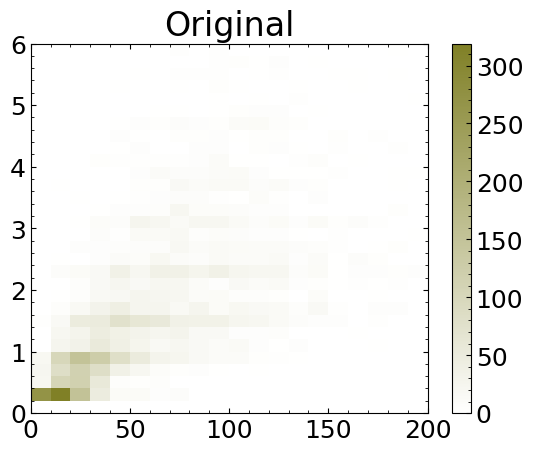

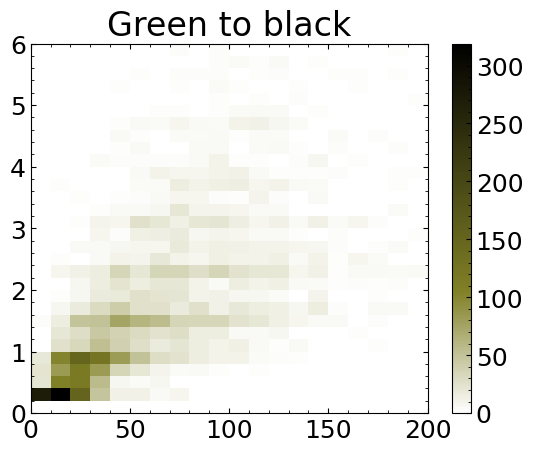

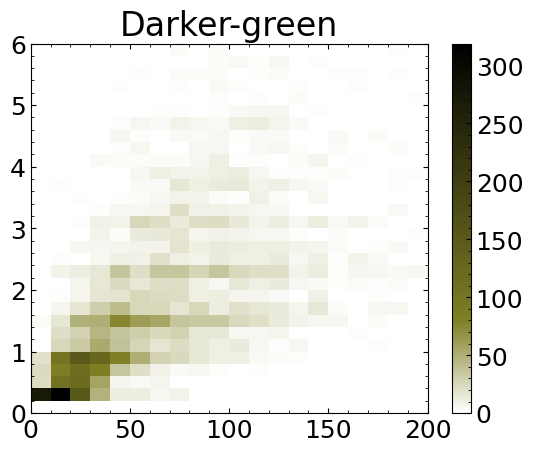

In [21]:
plt.hist2d(seps,timetilmerge,range=[[0,200],[0,6]],bins=[20,30],cmap=green_map)
plt.colorbar()
plt.title("Original")
plt.show()

plt.hist2d(seps,timetilmerge,range=[[0,200],[0,6]],bins=[20,30],cmap=dark_green)
plt.colorbar()
plt.title("Green to black")
plt.show()

plt.hist2d(seps,timetilmerge,range=[[0,200],[0,6]],bins=[20,30],cmap=darkest_green)
plt.colorbar()
plt.title("Darker-green")
plt.show()

In [22]:
nonzero = low_all['Separations'][:,40]!=0
nonnan = ~np.isnan(low_all['Separations'][:,40])
mergers = low_all['MergeFlag']

ispost = low_all['PostInfall'][:,40]
isafter = low_all["InfallSnapshot"] <= 40

mask = nonzero&nonnan&mergers&ispost
print(f"Remaining pairs: {np.count_nonzero(mask)} out of {len(low_all['Separations'])}")
seps = low_all['Separations'][:,40][mask]
mergesnap = low_all['MergeSnapshot'][mask]
mergetimes = convert["Lookback Time"][mergesnap]
timetilmerge = convert["Lookback Time"][40] - mergetimes

print(nonzero.shape)
print(nonnan.shape)
print(mergers.shape)
print(ispost.shape)
print(isafter.shape)

Remaining pairs: 5655 out of 22213
(22213,)
(22213,)
(22213,)
(22213,)
(22213,)


In [23]:
convert["Redshift"][21]

4.0079451114652676

In [24]:
i=67
# - low sep first! 
nonzero = low_all['Separations'][:,i]!=0
nonnan = ~np.isnan(low_all['Separations'][:,i])
mergers = low_all['MergeFlag']
afterinfall = low_all["InfallSnapshot"] <= i

mask = nonzero&nonnan&mergers&afterinfall

seps = low_all['Separations'][:,i][mask]
mergesnap = low_all['MergeSnapshot'][mask]
mergetimes = convert["Lookback Time"][mergesnap]
timetilmerge = convert["Lookback Time"][i] - mergetimes

Remaining pairs: 2716 out of 22213
Remaining pairs: 4535 out of 22213
Remaining pairs: 5655 out of 22213
Remaining pairs: 5798 out of 22213
Remaining pairs: 4084 out of 22213
Remaining pairs: 2427 out of 22213


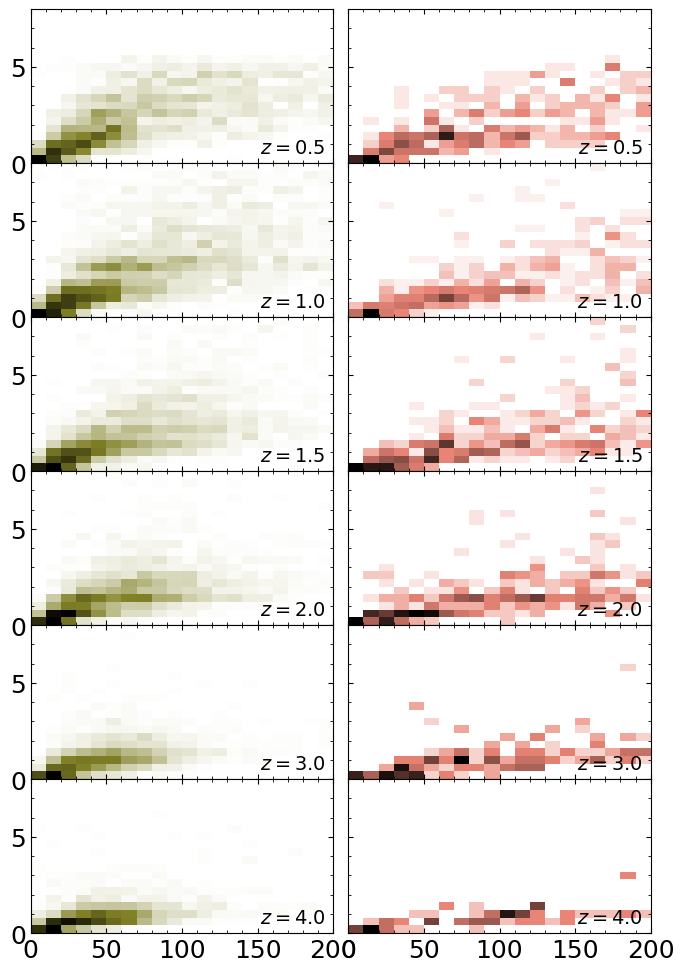

In [25]:
fig, ax = plt.subplots(6, 2, figsize=(8,12),sharey=True, sharex=True, 
                       gridspec_kw={'width_ratios': [1,1], 
                                    'height_ratios':[1,1,1,1,1,1],
                                    'wspace': 0.05,
                                    "hspace":0.0})

for en,i in enumerate([67,50,40,33,25,21]):
    # - low sep first! 
    nonzero = low_all['Separations'][:,i]!=0
    nonnan = ~np.isnan(low_all['Separations'][:,i])
    mergers = low_all['MergeFlag']
    afterinfall = low_all["InfallSnapshot"] <= i

    mask = nonzero&nonnan&mergers&afterinfall
          
    seps = low_all['Separations'][:,i][mask]
    mergesnap = low_all['MergeSnapshot'][mask]
    mergetimes = convert["Lookback Time"][mergesnap]
    timetilmerge = convert["Lookback Time"][i] - mergetimes
    
    print(f"Remaining pairs: {np.count_nonzero(mask)} out of {len(low_all['Separations'])}")

    _,_,_,im0 = ax[en][0].hist2d(seps,timetilmerge,range=[[0,200],[0,8]],bins=[int(20),int(20)],cmap=dark_green)
          

    ax[en][0].text(195,0.5,str(r"$z=$"+f"{convert['Redshift'][i]:1.1f}"),ha='right',fontsize=14)       
          
    nonzero = high_all['Separations'][:,i]!=0
    nonnan = ~np.isnan(high_all['Separations'][:,i])
    mergers = high_all['MergeFlag']
    afterinfall = high_all["InfallSnapshot"] <= i

    mask = nonzero&nonnan&mergers&afterinfall
          
    seps = high_all['Separations'][:,i][mask]
    mergesnap = high_all['MergeSnapshot'][mask]
    mergetimes = convert["Lookback Time"][mergesnap]
    timetilmerge = convert["Lookback Time"][i] - mergetimes      
          
          
    _,_,_,im1 = ax[en][1].hist2d(seps,timetilmerge,range=[[0,200],[0,8]],bins=[int(20),int(20)],cmap=darkest_pink)
                               
                               
    ax[en][1].text(195,0.5,str(r"$z=$"+f"{convert['Redshift'][i]:1.1f}"),ha='right',fontsize=14)                                      

#     # - colorbar 1
#     cax = fig.add_axes([0.47, 0.25, 0.01, 0.6])
#     fig1 = fig.colorbar(im0, cax=cax, aspect=30, location="left",shrink=0.8,pad=0.01)    
#     fig1.ax.tick_params(labelsize=14)

#     # - colorbar 2
#     cax = fig.add_axes([0.87, 0.25, 0.01, 0.6])
#     fig2 = fig.colorbar(im1, cax=cax,aspect=30,location="left",shrink=0.8,pad=0.01)
#     fig2.ax.tick_params(labelsize=14)


        
# ax[0].set_ylabel("Time until merger [Gyr]") 
# ax[0].set_title("Low-mass pairs",fontsize=18,color=palette['low']) 
# ax[1].set_title("High-mass  pairs",fontsize=18,color=palette['high']) 
# fig.supxlabel(r"Redshift z",fontsize=18)
# plt.savefig("../../plots/bet-on-it/3_Timevsz-2d.png")

plt.show()

In [330]:
print(high_all['Separations'][:,67]!=0)

[False False False ...  True  True  True]


Remaining pairs: 2716 out of 22213
Remaining pairs: 4535 out of 22213
Remaining pairs: 5655 out of 22213
Remaining pairs: 5798 out of 22213
Remaining pairs: 4084 out of 22213
Remaining pairs: 2427 out of 22213


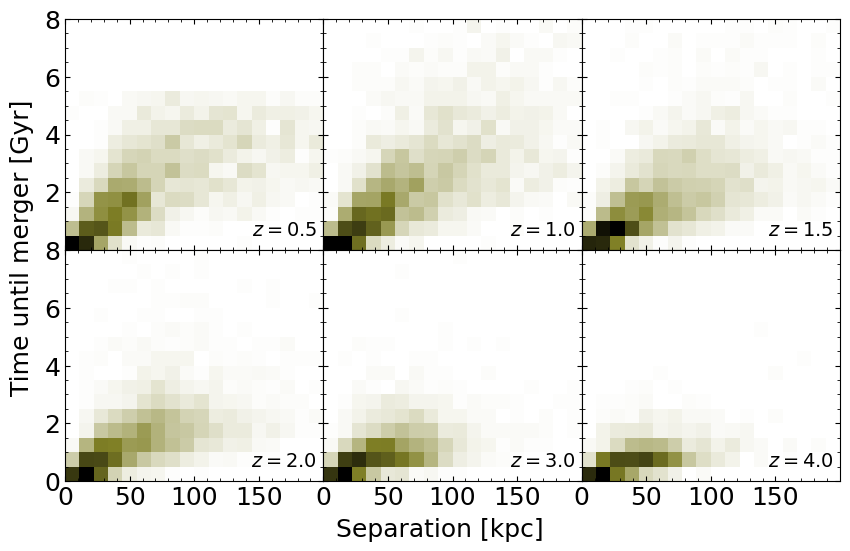

In [26]:
fig, ax = plt.subplots(2, 3, figsize=(10,6),sharey='row', sharex=True, 
                       gridspec_kw={'width_ratios': [1,1,1], 
                                    'height_ratios':[1,1],
                                    'wspace': 0.00,
                                    "hspace":0.0})
ind = 0 
rows = [0,1]
cols = [0,1,2]
snaps = [67,50,40,33,25,21]
for i in rows:
    for j in cols: 
#     for en,i in enumerate():
    # - low sep first! 
        nonzero = low_all['Separations'][:,snaps[ind]]!=0
        nonnan = ~np.isnan(low_all['Separations'][:,snaps[ind]])
        mergers = low_all['MergeFlag']
        afterinfall = low_all["InfallSnapshot"] <= snaps[ind]

        mask = nonzero&nonnan&mergers&afterinfall

        seps = low_all['Separations'][:,snaps[ind]][mask]
        mergesnap = low_all['MergeSnapshot'][mask]
        mergetimes = convert["Lookback Time"][mergesnap]
        timetilmerge = convert["Lookback Time"][snaps[ind]] - mergetimes

        print(f"Remaining pairs: {np.count_nonzero(mask)} out of {len(low_all['Separations'])}")

        h,_,_,im0 = ax[i][j].hist2d(seps,timetilmerge,range=[[0,200],[0,8]],bins=[int(18),int(16)],cmap=dark_green,weights=np.ones(len(seps))/5798)
#         h,xedges,yedges = np.histogram2d(seps,timetilmerge,range=[[0,200],[0,8]],bins=[int(18),int(16)])
#         _,_,_,im0 = ax[i][j].hist2d(seps,timetilmerge,range=[[0,200],[0,8]],bins=[int(20),int(20)],cmap=dark_green)
#         X, Y = np.meshgrid(xedges, yedges)

#         ax[i][j].pcolormesh(X, Y, h)
#         fig.colorbar(im0, ax=ax[i][j], aspect=30, location="right",shrink=0.8,pad=0.01)
#         im.set_data()
#               ax[i][j].add_image(im)
#         ax[i][j].imshow(h)
        ax[i][j].text(195,0.5,str(r"$z=$"+f"{convert['Redshift'][snaps[ind]]:1.1f}"),
                                  ha='right',fontsize=14)
        ax[i][j].set_xticks(ticks=np.arange(0,200,50))

        ind += 1
                      
                      
                      
#         ax[en][1].text(195,0.5,str(r"$z=$"+f"{convert['Redshift'][i]:1.1f}"),ha='right',fontsize=14)                                      

#     # - colorbar 1
#     cax = fig.add_axes([0.47, 0.25, 0.01, 0.6])
#     fig1 = fig.colorbar(im0, cax=cax, aspect=30, location="left",shrink=0.8,pad=0.01)    
#     fig1.ax.tick_params(labelsize=14)

#     # - colorbar 2
#     cax = fig.add_axes([0.87, 0.25, 0.01, 0.6])
#     fig2 = fig.colorbar(im1, cax=cax,aspect=30,location="left",shrink=0.8,pad=0.01)
#     fig2.ax.tick_params(labelsize=14)

ax[0][0].set_yticks(ticks=np.arange(2,9,2))
ax[1][0].set_yticks(ticks=np.arange(0,9,2))
        
# ax[0].set_ylabel("Time until merger [Gyr]") 
# ax[0].set_title("Low-mass pairs",fontsize=18,color=palette['low']) 
# ax[1].set_title("High-mass  pairs",fontsize=18,color=palette['high']) 
fig.supxlabel(r"Separation [kpc]",fontsize=18)
fig.supylabel(r"Time until merger [Gyr]",fontsize=18,x=0.07)

# plt.savefig("../../plots/bet-on-it/3_Timevsz-2d.png")
plt.savefig("../../plots/bet-on-it/3_Timevsseplow-2d.png")


plt.show()

Remaining pairs: 639 out of 3039
Remaining pairs: 874 out of 3039
Remaining pairs: 792 out of 3039
Remaining pairs: 603 out of 3039
Remaining pairs: 250 out of 3039
Remaining pairs: 95 out of 3039


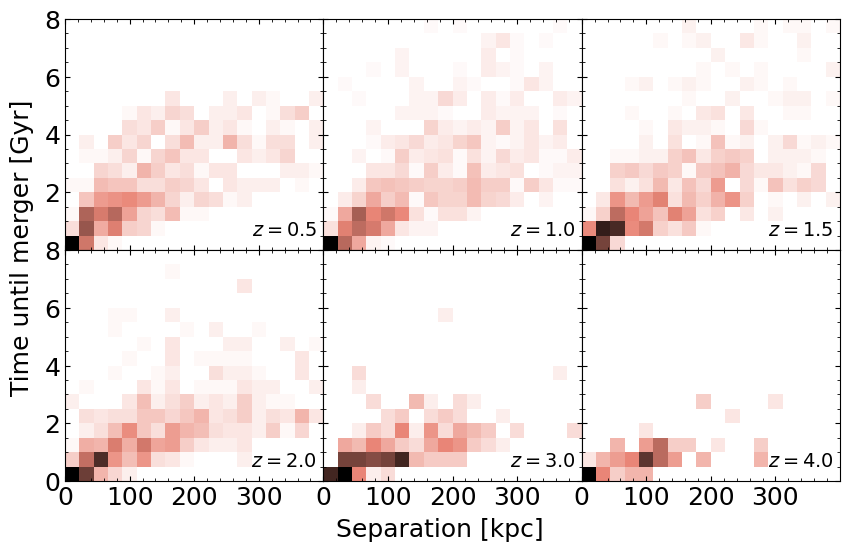

In [27]:
fig, ax = plt.subplots(2, 3, figsize=(10,6),sharey='row', sharex=True, 
                       gridspec_kw={'width_ratios': [1,1,1], 
                                    'height_ratios':[1,1],
                                    'wspace': 0.00,
                                    "hspace":0.0})
ind = 0 
rows = [0,1]
cols = [0,1,2]
snaps = [67,50,40,33,25,21]
for i in rows:
    for j in cols: 
#     for en,i in enumerate():
    # - high sep first! 
        nonzero = high_all['Separations'][:,snaps[ind]]!=0
        nonnan = ~np.isnan(high_all['Separations'][:,snaps[ind]])
        mergers = high_all['MergeFlag']
        afterinfall = high_all["InfallSnapshot"] <= snaps[ind]

        mask = nonzero&nonnan&mergers&afterinfall

        seps = high_all['Separations'][:,snaps[ind]][mask]
        mergesnap = high_all['MergeSnapshot'][mask]
        mergetimes = convert["Lookback Time"][mergesnap]
        timetilmerge = convert["Lookback Time"][snaps[ind]] - mergetimes   

        print(f"Remaining pairs: {np.count_nonzero(mask)} out of {len(high_all['Separations'])}")

        h,_,_,im0 = ax[i][j].hist2d(seps,timetilmerge,range=[[0,400],[0,8]],bins=[int(18),int(16)],cmap=dark_pink,weights=np.ones(len(seps))/5798)
#         h,xedges,yedges = np.histogram2d(seps,timetilmerge,range=[[0,200],[0,8]],bins=[int(18),int(16)])
#         _,_,_,im0 = ax[i][j].hist2d(seps,timetilmerge,range=[[0,200],[0,8]],bins=[int(20),int(20)],cmap=dark_green)
#         X, Y = np.meshgrid(xedges, yedges)

#         ax[i][j].pcolormesh(X, Y, h)
#         fig.colorbar(im0, ax=ax[i][j], aspect=30, location="right",shrink=0.8,pad=0.01)
#         im.set_data()
#               ax[i][j].add_image(im)
#         ax[i][j].imshow(h)
        ax[i][j].text(390,0.5,str(r"$z=$"+f"{convert['Redshift'][snaps[ind]]:1.1f}"),
                                  ha='right',fontsize=14)
        ax[i][j].set_xticks(ticks=np.arange(0,400,100))

        ind += 1
                      
                      
                      
#         ax[en][1].text(195,0.5,str(r"$z=$"+f"{convert['Redshift'][i]:1.1f}"),ha='right',fontsize=14)                                      

#     # - colorbar 1
#     cax = fig.add_axes([0.47, 0.25, 0.01, 0.6])
#     fig1 = fig.colorbar(im0, cax=cax, aspect=30, location="left",shrink=0.8,pad=0.01)    
#     fig1.ax.tick_params(labelsize=14)

#     # - colorbar 2
#     cax = fig.add_axes([0.87, 0.25, 0.01, 0.6])
#     fig2 = fig.colorbar(im1, cax=cax,aspect=30,location="left",shrink=0.8,pad=0.01)
#     fig2.ax.tick_params(labelsize=14)

ax[0][0].set_yticks(ticks=np.arange(2,9,2))
ax[1][0].set_yticks(ticks=np.arange(0,9,2))
        
# ax[0].set_ylabel("Time until merger [Gyr]") 
# ax[0].set_title("Low-mass pairs",fontsize=18,color=palette['low']) 
# ax[1].set_title("High-mass  pairs",fontsize=18,color=palette['high']) 
fig.supxlabel(r"Separation [kpc]",fontsize=18)
fig.supylabel(r"Time until merger [Gyr]",fontsize=18,x=0.07)

plt.savefig("../../plots/bet-on-it/3_Timevssephigh-2d.png")

plt.show()

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(10,6),sharey='row', sharex=True, 
                       gridspec_kw={'width_ratios': [1,1,1], 
                                    'height_ratios':[1,1],
                                    'wspace': 0.00,
                                    "hspace":0.0})
ind = 0 
rows = [0,1]
cols = [0,1,2]
snaps = [67,50,40,33,25,21]
for i in rows:
    for j in cols: 
#     for en,i in enumerate():
    # - low sep first! 
        nonzero = low_all['Separations'][:,snaps[ind]]!=0
        nonnan = ~np.isnan(low_all['Separations'][:,snaps[ind]])
        mergers = low_all['MergeFlag']
        afterinfall = low_all["InfallSnapshot"] <= snaps[ind]

        mask = nonzero&nonnan&mergers&afterinfall

        seps = low_all['Separations'][:,snaps[ind]][mask]
        mergesnap = low_all['MergeSnapshot'][mask]
        mergetimes = convert["Lookback Time"][mergesnap]
        timetilmerge = convert["Lookback Time"][snaps[ind]] - mergetimes

        print(f"Remaining pairs: {np.count_nonzero(mask)} out of {len(low_all['Separations'])}")

        h,_,_,im0 = ax[i][j].hist2d(seps,timetilmerge,range=[[0,200],[0,8]],bins=[int(18),int(16)],cmap=dark_green,weights=np.ones(len(seps))/5798)
#         h,xedges,yedges = np.histogram2d(seps,timetilmerge,range=[[0,200],[0,8]],bins=[int(18),int(16)])
#         _,_,_,im0 = ax[i][j].hist2d(seps,timetilmerge,range=[[0,200],[0,8]],bins=[int(20),int(20)],cmap=dark_green)
#         X, Y = np.meshgrid(xedges, yedges)

#         ax[i][j].pcolormesh(X, Y, h)
#         fig.colorbar(im0, ax=ax[i][j], aspect=30, location="right",shrink=0.8,pad=0.01)
#         im.set_data()
#               ax[i][j].add_image(im)
#         ax[i][j].imshow(h)
        ax[i][j].text(195,0.5,str(r"$z=$"+f"{convert['Redshift'][snaps[ind]]:1.1f}"),
                                  ha='right',fontsize=14)
        ax[i][j].set_xticks(ticks=np.arange(0,200,50))

        ind += 1
                      
                      
                      
#         ax[en][1].text(195,0.5,str(r"$z=$"+f"{convert['Redshift'][i]:1.1f}"),ha='right',fontsize=14)                                      

#     # - colorbar 1
#     cax = fig.add_axes([0.47, 0.25, 0.01, 0.6])
#     fig1 = fig.colorbar(im0, cax=cax, aspect=30, location="left",shrink=0.8,pad=0.01)    
#     fig1.ax.tick_params(labelsize=14)

#     # - colorbar 2
#     cax = fig.add_axes([0.87, 0.25, 0.01, 0.6])
#     fig2 = fig.colorbar(im1, cax=cax,aspect=30,location="left",shrink=0.8,pad=0.01)
#     fig2.ax.tick_params(labelsize=14)

ax[0][0].set_yticks(ticks=np.arange(2,9,2))
ax[1][0].set_yticks(ticks=np.arange(0,9,2))
        
# ax[0].set_ylabel("Time until merger [Gyr]") 
# ax[0].set_title("Low-mass pairs",fontsize=18,color=palette['low']) 
# ax[1].set_title("High-mass  pairs",fontsize=18,color=palette['high']) 
fig.supxlabel(r"Redshift z",fontsize=18)
fig.supylabel(r"Time until merger [Gyr]",fontsize=18,x=0.07)

# plt.savefig("../../plots/bet-on-it/3_Timevsz-2d.png")

plt.show()

In [318]:
h,_,_,_ = ax[0][0].hist2d(seps,timetilmerge,range=[[0,200],[0,8]],bins=[int(18),int(16)],cmap=dark_green,weights=np.ones(len(seps))/5798)
ax[0][0].imshow(h)
plt.show()

In [319]:
h

array([[0.04122111, 0.00413936, 0.00103484, 0.00017247, 0.        ,
        0.        , 0.        , 0.00017247, 0.        , 0.        ,
        0.00017247, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.05329424, 0.01966195, 0.00172473, 0.00172473, 0.00051742,
        0.00034495, 0.        , 0.        , 0.        , 0.00017247,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.02035185, 0.03208003, 0.0051742 , 0.00275957, 0.00068989,
        0.00034495, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.0122456 , 0.03173508, 0.00931356, 0.00310452, 0.00051742,
        0.00051742, 0.00034495, 0.        , 0.00017247, 0.        ,
        0.        , 0.00017247, 0.        , 0.        , 0.        ,
        0.        ],
       [0.00551914, 0.03449465, 0.00983098, 0.00327699, 0.00206968,
        0.00068989, 0.00051742, 

# All redshifts

## Histogram of merger redshift

In [13]:
reds_high = high_all['MergeRedshift'][high_all['MergeFlag']]
reds_low = low_all['MergeRedshift'][low_all['MergeFlag']]

In [56]:
convert["Redshift"][::-1]

array([2.22044605e-16, 9.52166697e-03, 2.39744284e-02, 3.37243719e-02,
       4.85236300e-02, 5.85073228e-02, 7.36613847e-02, 8.38844308e-02,
       9.94018026e-02, 1.09869940e-01, 1.25759332e-01, 1.41876204e-01,
       1.52748769e-01, 1.69252033e-01, 1.80385262e-01, 1.97284182e-01,
       2.14425036e-01, 2.25988386e-01, 2.43540182e-01, 2.61343256e-01,
       2.73353347e-01, 2.97717685e-01, 3.10074120e-01, 3.28829724e-01,
       3.47853842e-01, 3.60687657e-01, 3.80167867e-01, 3.99926965e-01,
       4.19968942e-01, 4.40297849e-01, 4.60917794e-01, 4.81832943e-01,
       5.03047523e-01, 5.24565820e-01, 5.46392183e-01, 5.75980845e-01,
       5.98543288e-01, 6.21428745e-01, 6.44641841e-01, 6.76110411e-01,
       7.00106354e-01, 7.32636182e-01, 7.57441373e-01, 7.91068249e-01,
       8.16709979e-01, 8.51470901e-01, 8.86896938e-01, 9.23000816e-01,
       9.50531352e-01, 9.97294226e-01, 1.03551045e+00, 1.07445789e+00,
       1.11415056e+00, 1.15460271e+00, 1.20625808e+00, 1.24847261e+00,
      

In [57]:
convert["Redshift"][:5:-1]

array([2.22044605e-16, 9.52166697e-03, 2.39744284e-02, 3.37243719e-02,
       4.85236300e-02, 5.85073228e-02, 7.36613847e-02, 8.38844308e-02,
       9.94018026e-02, 1.09869940e-01, 1.25759332e-01, 1.41876204e-01,
       1.52748769e-01, 1.69252033e-01, 1.80385262e-01, 1.97284182e-01,
       2.14425036e-01, 2.25988386e-01, 2.43540182e-01, 2.61343256e-01,
       2.73353347e-01, 2.97717685e-01, 3.10074120e-01, 3.28829724e-01,
       3.47853842e-01, 3.60687657e-01, 3.80167867e-01, 3.99926965e-01,
       4.19968942e-01, 4.40297849e-01, 4.60917794e-01, 4.81832943e-01,
       5.03047523e-01, 5.24565820e-01, 5.46392183e-01, 5.75980845e-01,
       5.98543288e-01, 6.21428745e-01, 6.44641841e-01, 6.76110411e-01,
       7.00106354e-01, 7.32636182e-01, 7.57441373e-01, 7.91068249e-01,
       8.16709979e-01, 8.51470901e-01, 8.86896938e-01, 9.23000816e-01,
       9.50531352e-01, 9.97294226e-01, 1.03551045e+00, 1.07445789e+00,
       1.11415056e+00, 1.15460271e+00, 1.20625808e+00, 1.24847261e+00,
      

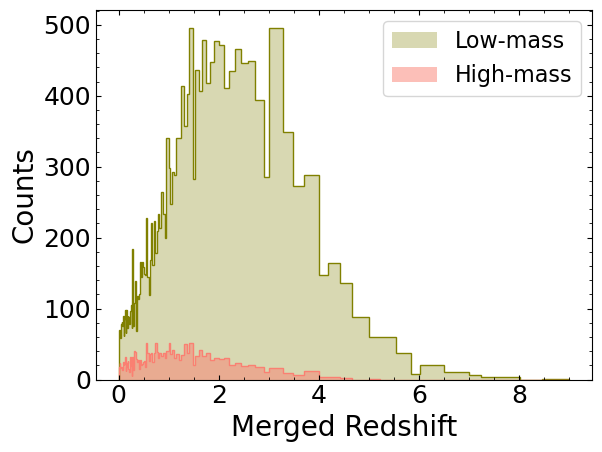

In [63]:
bins = convert["Redshift"][:5:-1]
vals_low,_ = np.histogram(reds_low,bins=bins)
vals_high,_ = np.histogram(reds_high,bins=bins)

plt.stairs(vals_low,edges=bins,color=palette['low'],alpha=0.3,fill=True,label="Low-mass")
plt.stairs(vals_high,edges=bins,color=palette['high'],alpha=0.5,fill=True,label="High-mass")

plt.stairs(vals_low,edges=bins,color=palette['low'],lw=1)
plt.stairs(vals_high,edges=bins,color=palette['high'],lw=1)

plt.ylabel("Counts")
plt.xlabel("Merged Redshift")
plt.legend(fontsize=16)
plt.show()

add the massive pairs to this and then make a few notes about how this follows/answers from the pair fraction evoltuion behavior found in the previous work

# Number of pairs

In [65]:
# take sep array, and replace nans with 0s, then call everything with non-0 separation a pair

zeroed_low = np.where(~np.isnan(low_all['Separations']),low_all['Separations'],0)

In [69]:
zeroed_low[100]

array([ 0.        ,  0.        , 36.04174153, 34.81861663, 33.33208044,
       31.31657467, 29.64973374, 25.96814217,  0.        , 14.09238442,
        8.40634018,  0.        ,  4.40245828,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [74]:
low_all['PostInfall'][0]

array([False, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [76]:
is_pair_low[low_all["MergeFlag"]]

array([[False,  True,  True, ..., False, False, False],
       [False,  True,  True, ..., False, False, False],
       [False,  True,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ...,  True,  True, False],
       [False, False, False, ...,  True,  True, False]])

In [43]:
zeroed_low = np.where(~np.isnan(low_all['Separations']),low_all['Separations'],0)
is_pair_low = (zeroed_low!=0)
is_post_low = low_all['PostInfall']
is_both_low = is_pair_low&is_post_low

num_pairs_low = np.sum(is_pair_low,axis=0)
num_post_low = np.sum(is_both_low,axis=0)
num_mpairs_low = np.sum(is_pair_low[low_all["MergeFlag"]],axis=0)
num_mpost_low = np.sum(is_both_low[low_all["MergeFlag"]],axis=0)

In [44]:
zeroed_high = np.where(~np.isnan(high_all['Separations']),high_all['Separations'],0)
is_pair_high = (zeroed_high!=0)
is_post_high = high_all['PostInfall']
is_both_high = is_pair_high&is_post_high

num_pairs_high = np.sum(is_pair_high,axis=0)
num_post_high = np.sum(is_both_high,axis=0)
num_mpairs_high = np.sum(is_pair_high[high_all["MergeFlag"]],axis=0)
num_mpost_high = np.sum(is_both_high[high_all["MergeFlag"]],axis=0)

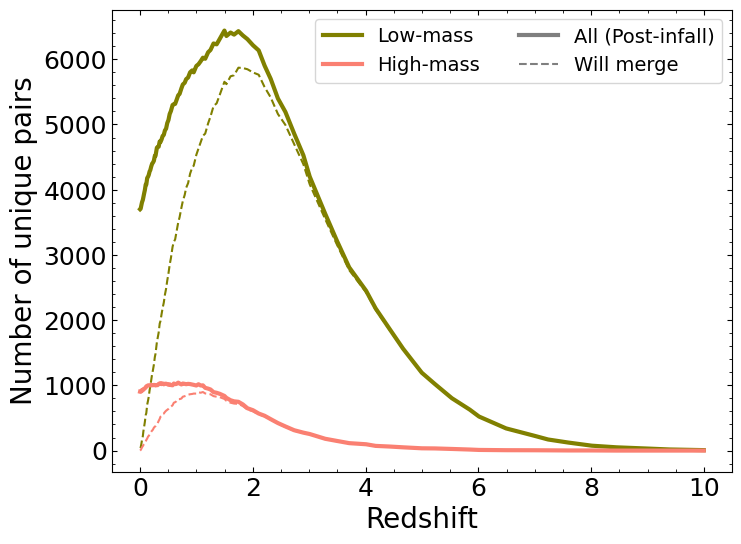

In [45]:
fig,ax = plt.subplots(figsize=(8,6))
plt.plot(convert["Redshift"][4:],num_post_low[4:],label='Low-mass',color=palette['low'],lw=3)
plt.plot(convert["Redshift"][4:],num_mpost_low[4:],color=palette['low'],lw=1.5,linestyle='dashed')

plt.plot(convert["Redshift"][4:],num_post_high[4:],label='High-mass',color=palette['high'],lw=3)
plt.plot(convert["Redshift"][4:],num_mpost_high[4:],color=palette['high'],lw=1.5,linestyle='dashed')




# plt.plot(0,0,label='Total',linestyle='dashed',color="tab:grey",lw=2)
# plt.plot(0,0,label='Same Group',linestyle='dotted',color="tab:grey",lw=3)
plt.plot(0,0,label='All (Post-infall)',color="tab:grey",lw=3)
plt.plot(0,0,label='Will merge',color="tab:grey",lw=1.5,linestyle='dashed')

# plt.plot(snap_dict["Redshift"],0.25/(1+(snap_dict["Redshift"]))**2.,label=r"$C(1+z)^{-2}$",color="tab:olive")
# plt.ylim(top=0.06)
# plt.xlim(right=10)
plt.legend(fontsize=14,ncol=2)
# plt.title("Number of unique pairs")
plt.xlabel("Redshift")
plt.ylabel("Number of unique pairs")
# plt.savefig("../../plots/bet-on-it/3_number_pairs.png")
plt.show()


# Time until merger

What if instead of taking all halos that merge at the given redshift, I FIRST take all the halos that are in the right separation bin at z=4 and calculate the average time until merger for only those halos? 

In [97]:
times_til_merger = {}
for dat,nam in [[low_all,"low"],[high_all,"high"]]:

    postinfall = dat["PostInfall"][dat['MergeFlag']]
    seps = dat['Separations'][dat['MergeFlag']]
    mergesnap = dat['MergeSnapshot'][dat['MergeFlag']]

    post_infall_seps = np.where(postinfall, seps, 0)
    in_bin = (post_infall_seps<50)&(post_infall_seps>10)

    times_til_merger[nam] = {}

    for i in range(len(in_bin[0])):
        merger_snaps = mergesnap[in_bin[:,i]]
        merger_lbt = convert["Lookback Time"][merger_snaps]
        times_til_merger[nam][i] = convert["Lookback Time"][i] - merger_lbt
    

In [98]:
counts_low = np.array([len(times_til_merger["low"][i]) for i in range(100)])
counts_high = np.array([len(times_til_merger["high"][i]) for i in range(100)])

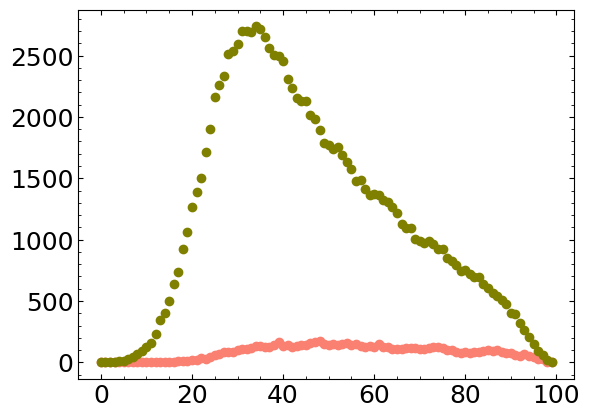

In [99]:
plt.scatter(convert['Snapshot'],counts_high,color=palette['high'])
plt.scatter(convert['Snapshot'],counts_low,color=palette['low'])

In [310]:
num_mpost_low

array([   0,    0,    1,    1,    7,   17,   31,   50,   75,  123,  170,
        224,  340,  522,  628,  802, 1018, 1190, 1555, 1848, 2160, 2427,
       2767, 3159, 3549, 4084, 4391, 4698, 4993, 5161, 5415, 5574, 5763,
       5798, 5847, 5866, 5871, 5755, 5739, 5619, 5655, 5458, 5325, 5281,
       5122, 5017, 4860, 4827, 4728, 4632, 4535, 4368, 4338, 4246, 4101,
       4029, 3920, 3825, 3724, 3577, 3499, 3349, 3238, 3200, 3125, 2951,
       2849, 2716, 2608, 2482, 2390, 2268, 2187, 2089, 1984, 1948, 1807,
       1720, 1663, 1484, 1434, 1313, 1225, 1181, 1081,  982,  929,  823,
        771,  704,  574,  544,  436,  378,  297,  222,  164,  110,   45,
          0])

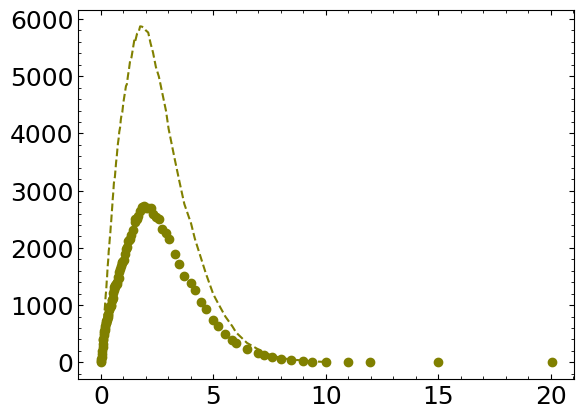

In [311]:
# plt.scatter(convert['Redshift'],counts_high,color=palette['high'])
plt.scatter(convert['Redshift'],counts_low,color=palette['low'])
plt.plot(convert["Redshift"][4:],num_mpost_low[4:],color=palette['low'],lw=1.5,linestyle='dashed')


In [343]:
meds_low, qs_low = [], []
meds_high, qs_high = [], []

for i in range(100):
    times = times_til_merger["low"][i]

    if len(times) == 0:
        meds_low.append(0)
        qs_low.append([0,0])
        
    else:
        med = np.median(times)
        meds_low.append(med)
        
        qs = np.quantile(times,np.array([0.25,0.75]))
        qs_low.append(qs)
        
        
    times = times_til_merger["high"][i]

    if len(times) == 0:
        meds_high.append(0)
        qs_high.append([0,0])
        
    else:
        med = np.median(times)
        meds_high.append(med)
        
        qs = np.quantile(times,np.array([0.25,0.75]))
        qs_high.append(qs)
        
meds_low = np.array(meds_low)
qs_low = np.array(qs_low)
meds_high = np.array(meds_high)
qs_high = np.array(qs_high)


(-0.09220723034001842, 2.5)

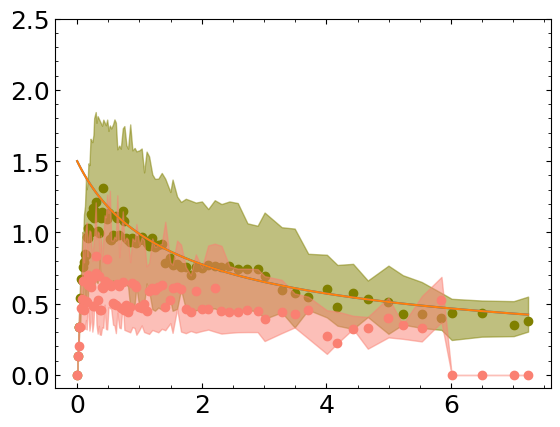

In [344]:
ind_cut = 10
reds = convert['Redshift'][ind_cut:]

plt.scatter(reds,meds_low[ind_cut:],color=palette['low'])
plt.fill_between(reds,qs_low[ind_cut:,0],qs_low[ind_cut:,1],color=palette['low'],alpha=0.5)

plt.scatter(reds,meds_high[ind_cut:],color=palette['high'])
plt.fill_between(reds,qs_high[ind_cut:,0],qs_high[ind_cut:,1],color=palette['high'],alpha=0.5)

plt.plot(reds,1.5/(1+reds)**0.6)
plt.plot(reds,1.5/(1+reds)**0.6)

plt.ylim(top=2.5)



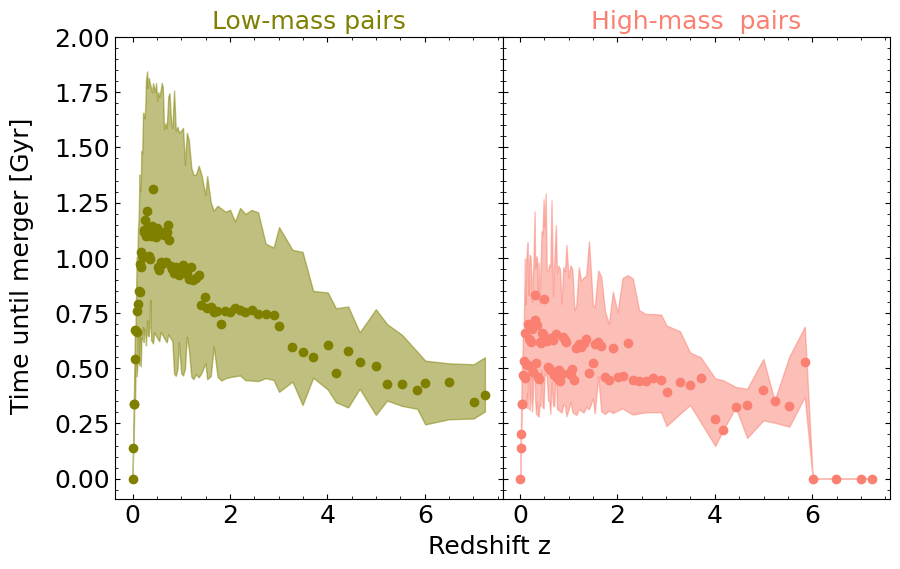

In [349]:
fig, ax = plt.subplots(1, 2, figsize=(10,6),sharey=True, sharex='col', 
                       gridspec_kw={'width_ratios': [1,1], 
                                    'height_ratios':[1],
                                    'wspace': 0.0,
                                    "hspace":0.0})


ind_cut = 10
reds = convert['Redshift'][ind_cut:]

ax[0].scatter(reds,meds_low[ind_cut:],color=palette['low'])
ax[0].fill_between(reds,qs_low[ind_cut:,0],qs_low[ind_cut:,1],color=palette['low'],alpha=0.5)

ax[1].scatter(reds,meds_high[ind_cut:],color=palette['high'])
ax[1].fill_between(reds,qs_high[ind_cut:,0],qs_high[ind_cut:,1],color=palette['high'],alpha=0.5)

# plt.plot(reds,1.5/(1+reds)**0.6)
# plt.plot(reds,1.5/(1+reds)**0.6)

plt.ylim(top=2)
ax[0].set_title("Low-mass pairs",fontsize=18,color=palette['low']) 
ax[1].set_title("High-mass  pairs",fontsize=18,color=palette['high']) 
fig.supxlabel(r"Redshift z",fontsize=18)
fig.supylabel(r"Time until merger [Gyr]",fontsize=18)
plt.savefig("../../plots/bet-on-it/3_Timevsz.png")
plt.show()


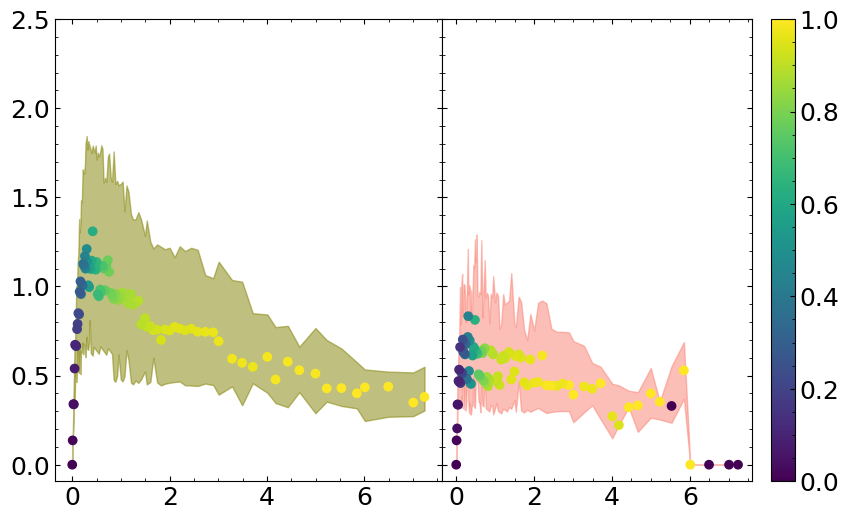

In [313]:
fig, ax = plt.subplots(1, 2, figsize=(10,6),sharey=True, sharex='col', 
                       gridspec_kw={'width_ratios': [1,1], 
                                    'height_ratios':[1],
                                    'wspace': 0.0,
                                    "hspace":0.0})


ind_cut_low = 10
ind_cut_low
reds = convert['Redshift'][ind_cut:]

ax[0].fill_between(reds,qs_low[ind_cut:,0],qs_low[ind_cut:,1],color=palette['low'],alpha=0.5)
l = ax[0].scatter(reds,meds_low[ind_cut:],c=frac_low['Fraction'][ind_cut:])
# plt.colorbar(l)

ax[1].fill_between(reds,qs_high[ind_cut:,0],qs_high[ind_cut:,1],color=palette['high'],alpha=0.5)
r = ax[1].scatter(reds,meds_high[ind_cut:],c=frac_high['Fraction'][ind_cut:])
plt.colorbar(r)
# plt.plot(reds,1.5/(1+reds)**0.6)
# plt.plot(reds,1.5/(1+reds)**0.6)

plt.ylim(top=2.5)
plt.show()


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,6),sharey=True, sharex='col', 
                       gridspec_kw={'width_ratios': [1,1], 
                                    'height_ratios':[1],
                                    'wspace': 0.0,
                                    "hspace":0.0})


ind_cut_low = 10
ind_cut_low
reds = convert['Redshift'][ind_cut:]

ax[0].fill_between(reds,qs_low[ind_cut:,0],qs_low[ind_cut:,1],color=palette['low'],alpha=0.5)
l = ax[0].scatter(reds,meds_low[ind_cut:],c=frac_low['Fraction'][ind_cut:])
# plt.colorbar(l)

ax[1].fill_between(reds,qs_high[ind_cut:,0],qs_high[ind_cut:,1],color=palette['high'],alpha=0.5)
ax[1].scatter(reds,meds_high[ind_cut:],c=frac_high['Fraction'][ind_cut:])
# plt.plot(reds,1.5/(1+reds)**0.6)
# plt.plot(reds,1.5/(1+reds)**0.6)

plt.ylim(top=2.5)
plt.show()


In [302]:
frac_high = pd.read_csv('../../data/big-bad/highmass_merger_fraction.csv',names=np.array(["Snapshot","Fraction"]))
frac_low = pd.read_csv('../../data/hail-mary/merger_fraction.csv',names=np.array(["Snapshot","Fraction"]))


In [298]:
frac_low['Fraction'].shape

(100,)

# 2D Hist of Time Til vs. Redshift

In [101]:
# make the x and y arrays for the 2d histogram
x = []
y = []
for i in range(100):
    p = times_til_merger['low'][i]
    redshift = convert['Redshift'][i]
    if len(p) == 0:
        continue
    else:
        xadd = [redshift]*len(p)
        x.extend(xadd)
        y.extend(p)
        
x = np.array(x)
y = np.array(y)

In [102]:
# make the x and y arrays for the 2d histogram
xh = []
yh = []
for i in range(100):
    p = times_til_merger['high'][i]
    redshift = convert['Redshift'][i]
    if len(p) == 0:
        continue
    else:
        xadd = [redshift]*len(p)
        xh.extend(xadd)
        yh.extend(p)
        
xh = np.array(xh)
yh = np.array(yh)

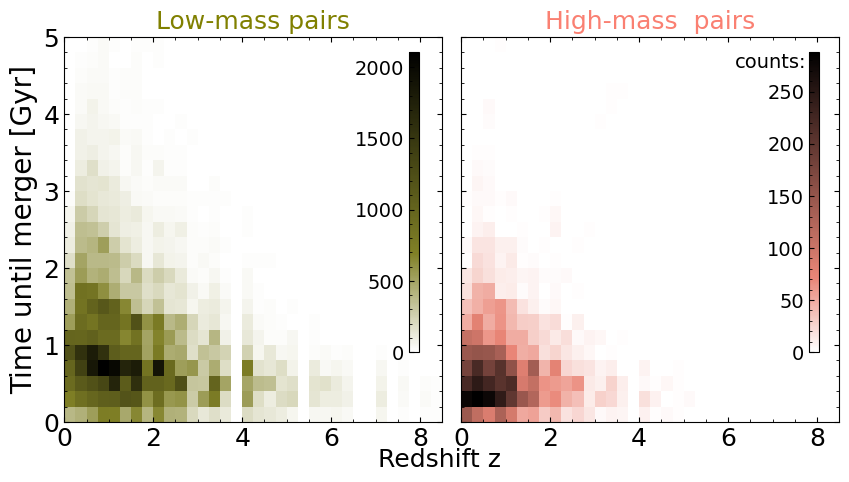

In [230]:
fig, ax = plt.subplots(1, 2, figsize=(10,5),sharey=True, sharex='col', 
                       gridspec_kw={'width_ratios': [1,1], 
                                    'height_ratios':[1],
                                    'wspace': 0.05,
                                    "hspace":0.0})

_,_,_,im0 = ax[0].hist2d(x,y,range=[[0,8.5],[0,5]],bins=[int(8.5/0.25),int(5/0.2)],cmap=dark_green)
_,_,_,im1 = ax[1].hist2d(xh,yh,range=[[0,8.5],[0,5]],bins=[int(8.5/0.25),int(5/0.2)],cmap=darkest_pink)

# - colorbar 1
cax = fig.add_axes([0.47, 0.25, 0.01, 0.6])
fig1 = fig.colorbar(im0, cax=cax, aspect=30, location="left",shrink=0.8,pad=0.01)    
fig1.ax.tick_params(labelsize=14)

# - colorbar 2
cax = fig.add_axes([0.87, 0.25, 0.01, 0.6])
fig2 = fig.colorbar(im1, cax=cax,aspect=30,location="left",shrink=0.8,pad=0.01)
fig2.ax.tick_params(labelsize=14)

ax[1].text(7.75,4.6,"counts:",ha='right',fontsize=14)
        
ax[0].set_ylabel("Time until merger [Gyr]") 
ax[0].set_title("Low-mass pairs",fontsize=18,color=palette['low']) 
ax[1].set_title("High-mass  pairs",fontsize=18,color=palette['high']) 
fig.supxlabel(r"Redshift z",fontsize=18)
plt.savefig("../../plots/bet-on-it/3_Timevsz-2d.png")

plt.show()

In [140]:
ax[0].hist2d(x,y,range=[[0,8.5],[0,5]],bins=[int(8.5/0.25),int(5/0.2)],cmap=dark_green)

(array([[3.890e+02, 7.190e+02, 9.230e+02, 1.000e+03, 1.212e+03, 1.004e+03,
         5.330e+02, 4.350e+02, 3.550e+02, 3.450e+02, 1.770e+02, 9.900e+01,
         7.800e+01, 5.700e+01, 1.700e+01, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00],
        [4.360e+02, 8.810e+02, 1.113e+03, 1.396e+03, 1.572e+03, 9.810e+02,
         9.180e+02, 8.460e+02, 8.650e+02, 5.380e+02, 4.960e+02, 3.750e+02,
         3.610e+02, 2.800e+02, 1.880e+02, 1.580e+02, 1.060e+02, 8.100e+01,
         7.800e+01, 4.700e+01, 3.200e+01, 3.100e+01, 2.100e+01, 1.400e+01,
         6.000e+00],
        [5.320e+02, 9.820e+02, 1.211e+03, 1.857e+03, 1.793e+03, 1.039e+03,
         8.340e+02, 1.013e+03, 8.250e+02, 4.240e+02, 3.820e+02, 4.050e+02,
         3.400e+02, 2.300e+02, 1.560e+02, 1.440e+02, 1.780e+02, 9.400e+01,
         5.900e+01, 6.000e+01, 7.200e+01, 4.000e+01, 2.700e+01, 1.800e+01,
         1.500e+01],
        [7.300e+02, 1.069e+03, 1.322e

In [357]:
from matplotlib.colors import ListedColormap


In [366]:
N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(128/256, 1, N)[::-1]
vals[:, 1] = np.linspace(128/256, 1, N)[::-1]
vals[:, 2] = np.linspace(38/256, 1, N)[::-1]
green_map = ListedColormap(vals)


vals = np.ones((N, 4))
vals[:, 0] = np.linspace(234/256, 1, N)[::-1]
vals[:, 1] = np.linspace(134/256, 1, N)[::-1]
vals[:, 2] = np.linspace(119/256, 1, N)[::-1]
pink_map = ListedColormap(vals)


In [353]:
x.shape

(117528,)

In [330]:
y.shape


(117528,)


# Time til merger function

one last thing I want to try, is to bin at the lower redshifts. so anywhere the redshift spacing is <0.2 or so, just bin it ~~~ 
so have a list of redshifts:
reds = np.arange(0,10,0.2)
^ and use those as the bounds for finding things in this small separation range

In [28]:
def time_til_merger(lower=10, upper=50):
    times_dict = {}
    for dat,nam in [[low_all,"low"],[high_all,"high"]]:

        postinfall = dat["PostInfall"][dat['MergeFlag']]
        seps = dat['Separations'][dat['MergeFlag']]
        mergesnap = dat['MergeSnapshot'][dat['MergeFlag']]

        post_infall_seps = np.where(postinfall, seps, 0)
        in_bin = (post_infall_seps<50)&(post_infall_seps>10)

        times_dict[nam] = {}

        for i in range(len(in_bin[0])):
            merger_snaps = mergesnap[in_bin[:,i]]
            merger_lbt = convert["Lookback Time"][merger_snaps]
            times_dict[nam][i] = convert["Lookback Time"][i] - merger_lbt


    meds_low, qs_low = [], []
    meds_high, qs_high = [], []

    for i in range(100):
        times = times_dict["low"][i]

        if len(times) == 0:
            meds_low.append(0)
            qs_low.append([0,0])

        else:
            med = np.median(times)
            meds_low.append(med)

            qs = np.quantile(times,np.array([0.25,0.75]))
            qs_low.append(qs)


        times = times_til_merger["high"][i]

        if len(times) == 0:
            meds_high.append(0)
            qs_high.append([0,0])

        else:
            med = np.median(times)
            meds_high.append(med)

            qs = np.quantile(times,np.array([0.25,0.75]))
            qs_high.append(qs)

    mlow = np.array(meds_low)
    qlow = np.array(qs_low)
    mhigh = np.array(meds_high)
    qhigh = np.array(qs_high)
    
    return mlow, qlow, mhigh, qhigh, times_dict


In [29]:
mlow, qlow, mhigh, qhigh, times = time_til_merger()

NameError: name 'times_til_merger' is not defined

<ErrorbarContainer object of 3 artists>

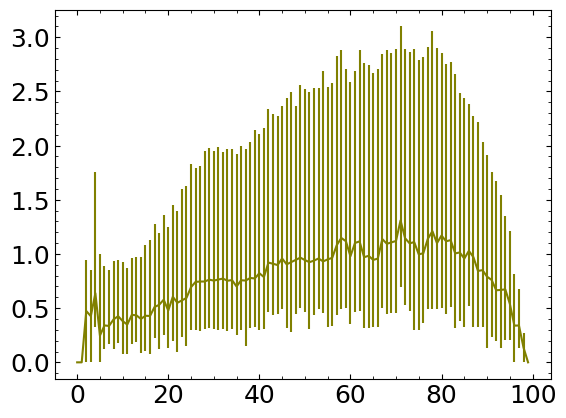

In [238]:
plt.errorbar(convert['Snapshot'],meds_low,yerr=qs_low.transpose(),color=palette['low'])
# plt.scatter(convert['Snapshot'],counts_low,color=palette['low'])

# Time to Merger vs. Redshift (at 6 separations chosen)

In [106]:
def get_median_times( data, convert, sep_lim, quantiles=[0.25,0.75]):

    nonzero = data['Separations']!=0 # n x 100
    nonnan = ~np.isnan(data['Separations']) # n x 100
    postinfall = data['PostInfall']!=0 # n x 100

    mask = nonnan&nonzero&postinfall

    seps_of_merger_pairs = np.where(mask, data['Separations'], 0)[data["MergeFlag"]]

    in_bin = (seps_of_merger_pairs>10)&(seps_of_merger_pairs < sep_lim)

    corresponding_merger_time_array = convert['Lookback Time'][data['MergeSnapshot'][data['MergeFlag']]]

    merger_time_matrix = np.tile(corresponding_merger_time_array,(100,1)).transpose()

    times_til_matrix = np.where(in_bin,convert['Lookback Time'],np.nan) - merger_time_matrix

    times_df = pd.DataFrame(times_til_matrix)

    meds = times_df.median().values
    qs = times_df.quantile(quantiles).values
    counts = times_df.count().values
    
    return counts, meds, qs

In [128]:
def get_median_times_scaled( data, convert, scsep_lim, quantiles=[0.25,0.75]):

    nonzero = data['Separations']!=0 # n x 100
    nonnan = ~np.isnan(data['Separations']) # n x 100
    postinfall = data['PostInfall']!=0 # n x 100

    mask = nonnan&nonzero&postinfall

    seps_of_merger_pairs = np.where(mask, data['Separations'], 0)[data["MergeFlag"]]
    scseps_of_merger_pairs = np.where(mask, data['SeparationsScaled'], 0)[data["MergeFlag"]]

    in_bin = (seps_of_merger_pairs>10)&(scseps_of_merger_pairs < scsep_lim)

    corresponding_merger_time_array = convert['Lookback Time'][data['MergeSnapshot'][data['MergeFlag']]]

    merger_time_matrix = np.tile(corresponding_merger_time_array,(100,1)).transpose()

    times_til_matrix = np.where(in_bin,convert['Lookback Time'],np.nan) - merger_time_matrix

    times_df = pd.DataFrame(times_til_matrix)

    meds = times_df.median().values
    qs = times_df.quantile(quantiles).values
    counts = times_df.count().values
    
    return counts, meds, qs

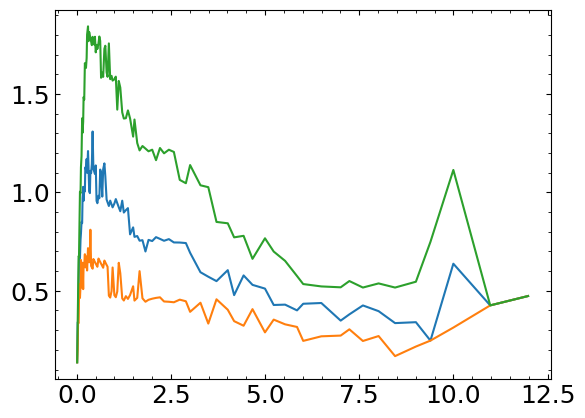

In [110]:
plt.plot(convert['Redshift'],get_median_times( low_all, convert, 50)[1])
plt.plot(convert['Redshift'],get_median_times( low_all, convert, 50)[2][0])
plt.plot(convert['Redshift'],get_median_times( low_all, convert, 50)[2][1])
plt.show()

In [113]:
np.where(convert['Redshift']<4.2)[0][0]

array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
       71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87,
       88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

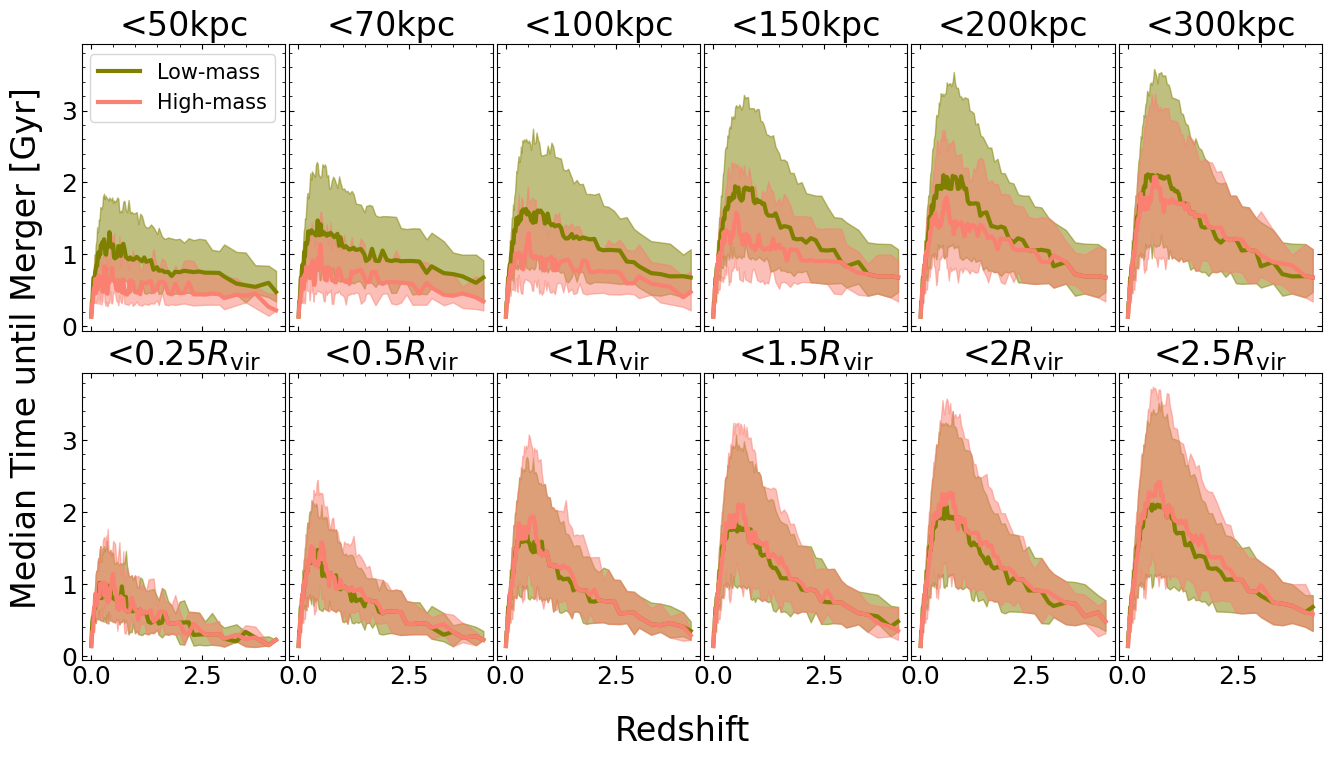

In [150]:
sepcut = [50,70,100,150, 200, 300]
vircut = [0.25,0.5,1,1.5,2, 2.5]
ind_cut = np.where(convert['Redshift']<4.2)[0][0]

fig, ax = plt.subplots(2, 6, figsize=(16,8), sharey=True, sharex=True, 
                       gridspec_kw={'width_ratios': [1,1,1,1,1,1], 'height_ratios':[1,1],
                                    'wspace': 0.02,"hspace":0.15})

for ind in range(6):
    ax[0][ind].set(title=f"<{sepcut[ind]}kpc")
    
    counts, meds, qs = get_median_times( low_all, convert, sepcut[ind])  
    
    ax[0][ind].plot(convert['Redshift'][ind_cut:],meds[ind_cut:],lw=3,color=palette['low'],label='Low-mass')
    ax[0][ind].fill_between(convert['Redshift'][ind_cut:], qs[0][ind_cut:], qs[1][ind_cut:],color=palette["low"],alpha=0.5)
    
    # massive physical
    counts, meds, qs = get_median_times( high_all, convert, sepcut[ind])
    
    ax[0][ind].plot(convert['Redshift'][ind_cut:],meds[ind_cut:],lw=3,color=palette['high'],label='High-mass')
    ax[0][ind].fill_between(convert['Redshift'][ind_cut:], qs[0][ind_cut:], qs[1][ind_cut:],color=palette["high"],alpha=0.5)

    
    ax[1][ind].set(title=f"<{vircut[ind]}"+r"$R_{\rm vir}$")
    
    counts, meds, qs = get_median_times_scaled( low_all, convert, vircut[ind])  
    
    ax[1][ind].plot(convert['Redshift'][ind_cut:],meds[ind_cut:],lw=3,color=palette['low'])
    ax[1][ind].fill_between(convert['Redshift'][ind_cut:], qs[0][ind_cut:], qs[1][ind_cut:],color=palette["low"],alpha=0.5)
 
    counts, meds, qs = get_median_times_scaled( high_all, convert, vircut[ind])  
    
    ax[1][ind].plot(convert['Redshift'][ind_cut:],meds[ind_cut:],lw=3,color=palette['high'])
    ax[1][ind].fill_between(convert['Redshift'][ind_cut:], qs[0][ind_cut:], qs[1][ind_cut:],color=palette["high"],alpha=0.5)
 
#############
#############

ax[0][0].legend(fontsize=15)
fig.supxlabel("Redshift",y=0.0)
fig.supylabel("Median Time until Merger [Gyr]",x=0.08)

# if save:
plt.savefig(f"{paths.path_plots}bet-on-it/3_time_til_merger.png",bbox_inches='tight',facecolor="white")
plt.show()

# Time to merger All

In [7]:
def get_median_times_all( data, convert, quantiles=[0.25,0.75]):

    nonzero = data['Separations']!=0 # n x 100
    nonnan = ~np.isnan(data['Separations']) # n x 100
    postinfall = data['PostInfall']!=0 # n x 100

    mask = nonnan&nonzero&postinfall

    seps_of_merger_pairs = np.where(mask, data['Separations'], 0)[data["MergeFlag"]]

    in_bin = (seps_of_merger_pairs>10)

    corresponding_merger_time_array = convert['Lookback Time'][data['MergeSnapshot'][data['MergeFlag']]]

    merger_time_matrix = np.tile(corresponding_merger_time_array,(100,1)).transpose()

    times_til_matrix = np.where(in_bin,convert['Lookback Time'],np.nan) - merger_time_matrix

    times_df = pd.DataFrame(times_til_matrix)

    meds = times_df.median().values
    qs = times_df.quantile(quantiles).values
    counts = times_df.count().values
    
    return counts, meds, qs

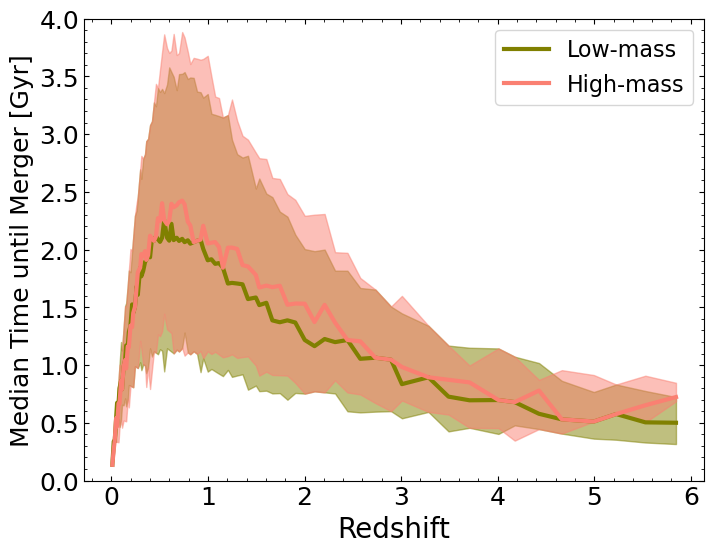

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8,6), sharey=True, sharex=True, 
                       gridspec_kw={'width_ratios': [1], 'height_ratios':[1],
                                    'wspace': 0.02,"hspace":0.15})

ind_cut = np.where(convert['Redshift']<6)[0][0]

counts, meds, qs = get_median_times_all( low_all, convert)  

ax.plot(convert['Redshift'][ind_cut:],meds[ind_cut:],color=palette["low"],lw=3,label='Low-mass')
ax.fill_between(convert['Redshift'][ind_cut:], qs[0][ind_cut:], qs[1][ind_cut:],color=palette["low"],alpha=0.5)

counts, meds, qs = get_median_times_all( high_all, convert)  

ax.plot(convert['Redshift'][ind_cut:],meds[ind_cut:],color=palette["high"],lw=3,label='High-mass')
ax.fill_between(convert['Redshift'][ind_cut:], qs[0][ind_cut:], qs[1][ind_cut:],color=palette["high"],alpha=0.5)
ax.set_xlabel("Redshift",y=0.0)
ax.set_ylabel("Median Time until Merger [Gyr]",x=0.08,fontsize=18)
ax.legend(fontsize=16)
ax.set_ylim(0,4)


# plt.savefig(f"{paths.path_plots}bet-on-it/3_time_til_merger_full.png",bbox_inches='tight',facecolor="white")


plt.show() 

In [10]:
_, meds_low, _ = get_median_times_all( low_all, convert)  
_, meds_high, _ = get_median_times_all( high_all, convert)  

In [16]:
mask = convert["Redshift"] < 6

In [21]:
np.nanmax(meds_low[mask])

2.254791259315768

In [19]:
np.where(meds_low[mask] == np.nanmax(meds_low[mask]))

(array([51]),)

In [23]:
convert["Redshift"][mask][51]

0.5463921831410221

In [18]:
np.nanmax(meds_high[mask])

2.4236314913348576

In [22]:
np.where(meds_high[mask] == np.nanmax(meds_high[mask]))

(array([44]),)

In [24]:
convert["Redshift"][mask][44]

0.7326361820223115

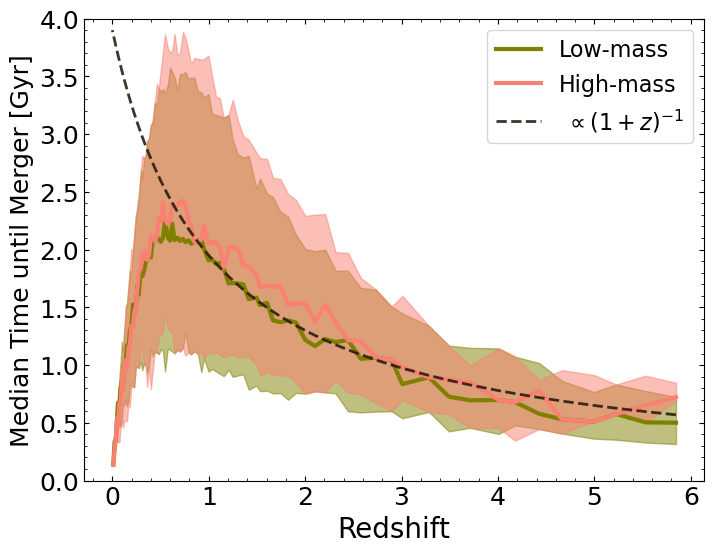

In [270]:
fig, ax = plt.subplots(1, 1, figsize=(8,6), sharey=True, sharex=True, 
                       gridspec_kw={'width_ratios': [1], 'height_ratios':[1],
                                    'wspace': 0.02,"hspace":0.15})

ind_cut = np.where(convert['Redshift']<6)[0][0]

counts, meds, qs = get_median_times_all( low_all, convert)  

ax.plot(convert['Redshift'][ind_cut:],meds[ind_cut:],color=palette["low"],lw=3,label='Low-mass')
ax.fill_between(convert['Redshift'][ind_cut:], qs[0][ind_cut:], qs[1][ind_cut:],color=palette["low"],alpha=0.5)

counts, meds, qs = get_median_times_all( high_all, convert)  

ax.plot(convert['Redshift'][ind_cut:],meds[ind_cut:],color=palette["high"],lw=3,label='High-mass')
ax.fill_between(convert['Redshift'][ind_cut:], qs[0][ind_cut:], qs[1][ind_cut:],color=palette["high"],alpha=0.5)


z = convert['Redshift'][ind_cut:]
zz = 3.9/((1+z)**1)
ax.plot(z,zz,label=r" $\propto(1+z)^{-1}$",color=palette['difference'],alpha=0.9,lw=2,linestyle='dashed')
ax.set_ylim(0,4)


ax.set_xlabel("Redshift",y=0.0)
ax.set_ylabel("Median Time until Merger [Gyr]",x=0.08,fontsize=18)
ax.legend(fontsize=16)


plt.savefig(f"{paths.path_plots}bet-on-it/3_time_til_merger_full_fit.png",bbox_inches='tight',facecolor="white")


plt.show() 

# Merger fraction vs. the above

In [153]:
data = low_all
nonzero = data['Separations']!=0 # n x 100
nonnan = ~np.isnan(data['Separations']) # n x 100
postinfall = data['PostInfall']!=0 # n x 100

mask = nonnan&nonzero&postinfall

seps_of_merger_pairs = np.where(mask, data['Separations'], 0)

in_bin = (seps_of_merger_pairs>10)&(seps_of_merger_pairs < 100)

In [165]:
array2/array1

array([   0,    0,    1,    1,    7,   17,   31,   49,   74,  116,  156,
        209,  304,  469,  555,  697,  885, 1016, 1352, 1585, 1876, 2089,
       2350, 2709, 3054, 3536, 3749, 3921, 4151, 4231, 4392, 4522, 4578,
       4589, 4614, 4549, 4466, 4325, 4251, 4173, 4141, 3975, 3839, 3727,
       3614, 3565, 3418, 3374, 3274, 3175, 3091, 2953, 2964, 2814, 2710,
       2652, 2571, 2536, 2449, 2381, 2362, 2275, 2161, 2108, 2059, 2014,
       1920, 1840, 1772, 1692, 1652, 1612, 1583, 1532, 1464, 1433, 1351,
       1302, 1259, 1154, 1122, 1060,  994,  962,  891,  823,  760,  695,
        644,  570,  469,  449,  344,  283,  216,  152,   93,   64,   20,
          0])

In [185]:
def get_merger_fraction( data, convert, sep_lim, quantiles=[0.25,0.75]):

    nonzero = data['Separations']!=0 # n x 100
    nonnan = ~np.isnan(data['Separations']) # n x 100
    postinfall = data['PostInfall']!=0 # n x 100

    mask = nonnan&nonzero&postinfall

    seps_of_merger_pairs = np.where(mask, data['Separations'], 0)

    in_bin = (seps_of_merger_pairs>10)&(seps_of_merger_pairs < sep_lim)
    lower_lim = (seps_of_merger_pairs>10)

    
    total_in_sep_bin = np.sum(in_bin,axis=0)
    merge_in_sep_bin = np.sum(in_bin[data["MergeFlag"]],axis=0)
    
    frac_merge = np.where(total_in_sep_bin != 0, merge_in_sep_bin / total_in_sep_bin, np.nan)
    frac_total = merge_in_sep_bin / np.sum(mask&lower_lim,axis=0)

    
    return frac_merge, frac_total

In [184]:
def get_merger_fraction_scaled( data, convert, sep_lim, quantiles=[0.25,0.75]):

    nonzero = data['Separations']!=0 # n x 100
    nonnan = ~np.isnan(data['Separations']) # n x 100
    postinfall = data['PostInfall']!=0 # n x 100

    mask = nonnan&nonzero&postinfall

    seps_of_merger_pairs = np.where(mask, data['Separations'], 0)
    scseps_of_merger_pairs = np.where(mask, data['SeparationsScaled'], 0)

    in_bin = (seps_of_merger_pairs>10)&(scseps_of_merger_pairs < sep_lim)
    lower_lim = (seps_of_merger_pairs>10)
    
    total_in_sep_bin = np.sum(in_bin,axis=0)
    merge_in_sep_bin = np.sum(in_bin[data["MergeFlag"]],axis=0)
    
    frac_merge = merge_in_sep_bin / total_in_sep_bin
    frac_total = merge_in_sep_bin / np.sum(mask&lower_lim,axis=0)
    
    return frac_merge, frac_total

/tmp/ipykernel_67397/4171425619.py:18: RuntimeWarning: invalid value encountered in divide
  frac_merge = np.where(total_in_sep_bin != 0, merge_in_sep_bin / total_in_sep_bin, np.nan)
/tmp/ipykernel_67397/4171425619.py:19: RuntimeWarning: invalid value encountered in divide
  frac_total = merge_in_sep_bin / np.sum(mask&lower_lim,axis=0)


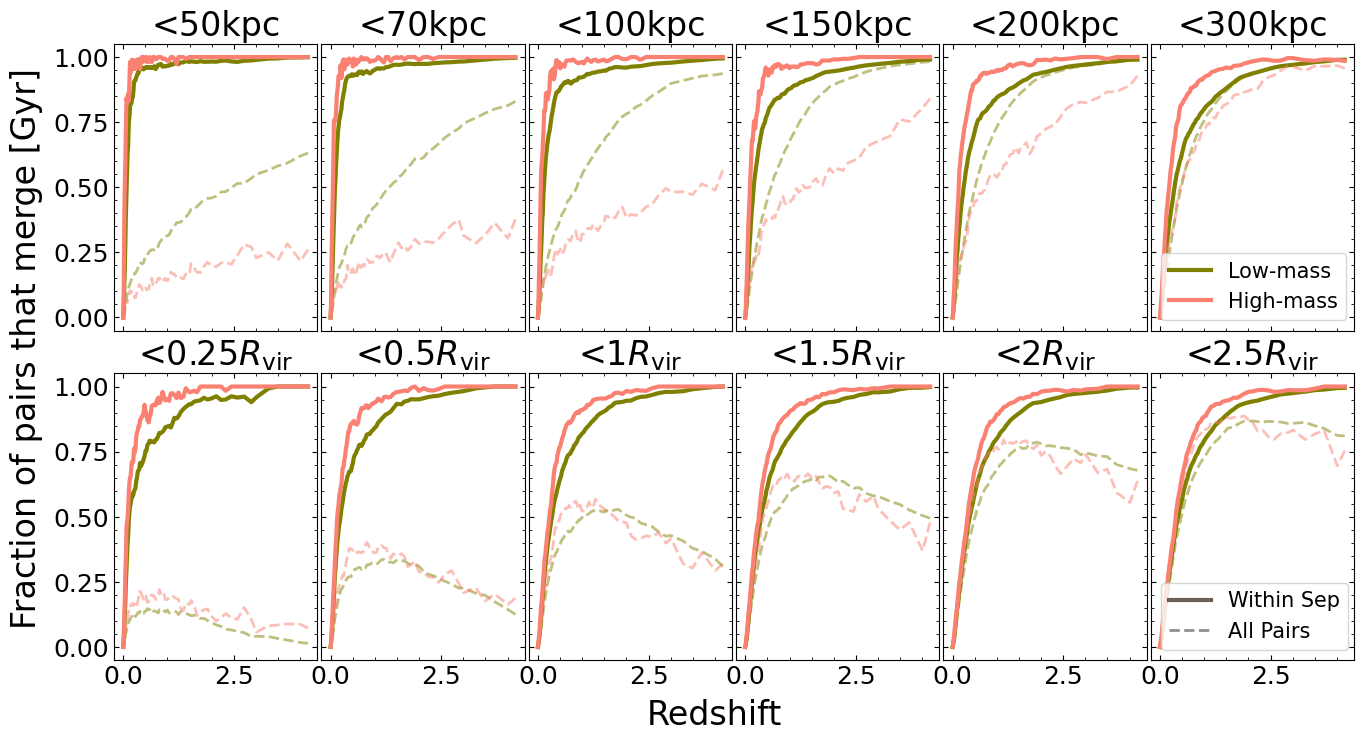

In [209]:
sepcut = [50,70,100,150, 200, 300]
vircut = [0.25,0.5,1,1.5,2, 2.5]
ind_cut = np.where(convert['Redshift']<4.2)[0][0]

fig, ax = plt.subplots(2, 6, figsize=(16,8), sharey=True, sharex=True, 
                       gridspec_kw={'width_ratios': [1,1,1,1,1,1], 'height_ratios':[1,1],
                                    'wspace': 0.02,"hspace":0.15})

for ind in range(6):
    ax[0][ind].set(title=f"<{sepcut[ind]}kpc")
    
    frac,frac_all = get_merger_fraction( low_all, convert, sepcut[ind])  
    ax[0][ind].plot(convert['Redshift'][ind_cut:],frac[ind_cut:],lw=3,color=palette['low'],label='Low-mass')
    ax[0][ind].plot(convert['Redshift'][ind_cut:],frac_all[ind_cut:],alpha=0.5,linestyle='dashed',lw=2,color=palette['low'])
#     ax[0][ind].fill_between(convert['Redshift'][ind_cut:], qs[0][ind_cut:], qs[1][ind_cut:],color=palette["low"],alpha=0.5)
    
#     # massive physical
    frac,frac_all = get_merger_fraction( high_all, convert, sepcut[ind])
    ax[0][ind].plot(convert['Redshift'][ind_cut:],frac[ind_cut:],lw=3,color=palette['high'],label='High-mass')
    ax[0][ind].plot(convert['Redshift'][ind_cut:],frac_all[ind_cut:],lw=2,alpha=0.5,linestyle='dashed',color=palette['high'])
#     ax[0][ind].fill_between(convert['Redshift'][ind_cut:], qs[0][ind_cut:], qs[1][ind_cut:],color=palette["high"],alpha=0.5)

    
    ax[1][ind].set(title=f"<{vircut[ind]}"+r"$R_{\rm vir}$")
    
    frac,frac_all = get_merger_fraction_scaled( low_all, convert, vircut[ind])  
    
    ax[1][ind].plot(convert['Redshift'][ind_cut:],frac[ind_cut:],lw=3, color=palette['low'])
    ax[1][ind].plot(convert['Redshift'][ind_cut:],frac_all[ind_cut:],lw=2,alpha=0.5,linestyle='dashed',color=palette['low'])
#     ax[1][ind].fill_between(convert['Redshift'][ind_cut:], qs[0][ind_cut:], qs[1][ind_cut:],color=palette["low"],alpha=0.5)
 
    frac,frac_all = get_merger_fraction_scaled( high_all, convert, vircut[ind])  
    
    ax[1][ind].plot(convert['Redshift'][ind_cut:],frac[ind_cut:],lw=3,color=palette['high'])
    ax[1][ind].plot(convert['Redshift'][ind_cut:],frac_all[ind_cut:],lw=2,alpha=0.5,linestyle='dashed',color=palette['high'])
#     ax[1][ind].fill_between(convert['Redshift'][ind_cut:], qs[0][ind_cut:], qs[1][ind_cut:],color=palette["high"],alpha=0.5)
 
#############
#############
ax[1][5].plot(0,0,lw=3,color=palette['difference'],alpha=0.7,label='Within Sep')
ax[1][5].plot(0,0,lw=2,linestyle='dashed',color=palette['difference'],alpha=0.5,label='All Pairs')


ax[0][5].legend(fontsize=15)
ax[1][5].legend(fontsize=15)
fig.supxlabel("Redshift",y=0.02)
fig.supylabel("Fraction of pairs that merge [Gyr]",x=0.06)

# if save:
plt.savefig(f"{paths.path_plots}bet-on-it/3_merger_fraction.png",bbox_inches='tight',facecolor="white")
plt.show()

/tmp/ipykernel_67397/4171425619.py:18: RuntimeWarning: invalid value encountered in divide
  frac_merge = np.where(total_in_sep_bin != 0, merge_in_sep_bin / total_in_sep_bin, np.nan)
/tmp/ipykernel_67397/4171425619.py:19: RuntimeWarning: invalid value encountered in divide
  frac_total = merge_in_sep_bin / np.sum(mask&lower_lim,axis=0)


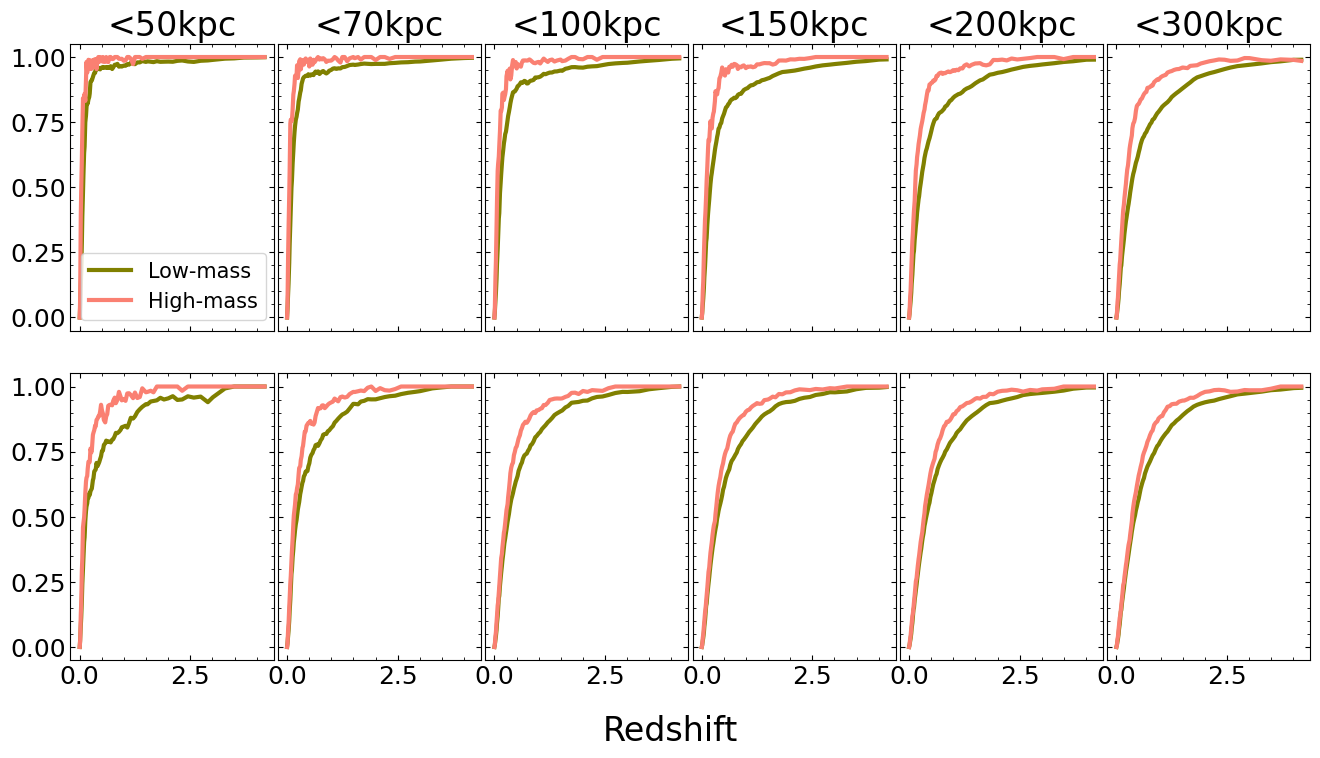

In [186]:
sepcut = [50,70,100,150, 200, 300]
vircut = [0.25,0.5,1,1.5,2, 2.5]
ind_cut = np.where(convert['Redshift']<4.2)[0][0]

fig, ax = plt.subplots(2, 6, figsize=(16,8), sharey=True, sharex=True, 
                       gridspec_kw={'width_ratios': [1,1,1,1,1,1], 'height_ratios':[1,1],
                                    'wspace': 0.02,"hspace":0.15})

for ind in range(6):
    ax[0][ind].set(title=f"<{sepcut[ind]}kpc")
    
    frac,frac_all = get_merger_fraction( low_all, convert, sepcut[ind])  
    
    ax[0][ind].plot(convert['Redshift'][ind_cut:],frac[ind_cut:],lw=3,color=palette['low'],label='Low-mass')
#     ax[0][ind].fill_between(convert['Redshift'][ind_cut:], qs[0][ind_cut:], qs[1][ind_cut:],color=palette["low"],alpha=0.5)
    
#     # massive physical
    frac,frac_all = get_merger_fraction( high_all, convert, sepcut[ind])
    
    ax[0][ind].plot(convert['Redshift'][ind_cut:],frac[ind_cut:],lw=3,color=palette['high'],label='High-mass')
#     ax[0][ind].fill_between(convert['Redshift'][ind_cut:], qs[0][ind_cut:], qs[1][ind_cut:],color=palette["high"],alpha=0.5)

    
#     ax[1][ind].set(title=f"<{vircut[ind]}"+r"$R_{\rm vir}$")
    
    frac,frac_all = get_merger_fraction_scaled( low_all, convert, vircut[ind])  
    
    ax[1][ind].plot(convert['Redshift'][ind_cut:],frac[ind_cut:],lw=3,color=palette['low'])
#     ax[1][ind].fill_between(convert['Redshift'][ind_cut:], qs[0][ind_cut:], qs[1][ind_cut:],color=palette["low"],alpha=0.5)
 
    frac,frac_all = get_merger_fraction_scaled( high_all, convert, vircut[ind])  
    
    ax[1][ind].plot(convert['Redshift'][ind_cut:],frac[ind_cut:],lw=3,color=palette['high'])
#     ax[1][ind].fill_between(convert['Redshift'][ind_cut:], qs[0][ind_cut:], qs[1][ind_cut:],color=palette["high"],alpha=0.5)
 
#############
#############

ax[0][0].legend(fontsize=15)
fig.supxlabel("Redshift",y=0.0)
# fig.supylabel("Median Time until Merger [Gyr]",x=0.08)

# if save:
# plt.savefig(f"{paths.path_plots}bet-on-it/3_merger_fraction.png",bbox_inches='tight',facecolor="white")
plt.show()

In [178]:
data=low_all
nonzero = data['Separations']!=0 # n x 100
nonnan = ~np.isnan(data['Separations']) # n x 100
postinfall = data['PostInfall']!=0 # n x 100

mask = nonnan&nonzero&postinfall

seps_of_merger_pairs = np.where(mask, data['Separations'], 0)
scseps_of_merger_pairs = np.where(mask, data['SeparationsScaled'], 0)

in_bin = (seps_of_merger_pairs>10)&(scseps_of_merger_pairs < 0.25)

total_in_sep_bin = np.sum(in_bin,axis=0)
merge_in_sep_bin = np.sum(in_bin[data["MergeFlag"]],axis=0)

frac_merge = np.where(total_in_sep_bin != 0, merge_in_sep_bin / total_in_sep_bin, np.nan)


/tmp/ipykernel_67397/1415805367.py:16: RuntimeWarning: invalid value encountered in divide
  frac_merge = np.where(total_in_sep_bin != 0, merge_in_sep_bin / total_in_sep_bin, np.nan)


In [ ]:
np.sum(mask,axis=0)

In [180]:
total_in_sep_bin

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   2,   0,   3,  16,  11,  28,  38,  67,  97, 135, 169,
       183, 258, 305, 346, 382, 466, 511, 572, 642, 692, 698, 756, 781,
       775, 810, 834, 872, 882, 821, 894, 899, 908, 907, 868, 945, 888,
       936, 982, 944, 955, 878, 910, 921, 932, 923, 960, 901, 929, 938,
       960, 930, 894, 903, 853, 874, 850, 872, 900, 887, 911, 878, 868,
       862, 845, 849, 804, 799, 850, 868, 863, 842, 809, 792, 846, 824,
       854, 829, 799, 798, 770, 796, 812, 738, 744])

In [182]:
merge_in_sep_bin/total_in_sep_bin

/tmp/ipykernel_67397/2932574769.py:1: RuntimeWarning: invalid value encountered in divide
  merge_in_sep_bin/total_in_sep_bin


array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
       1.        ,        nan, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.99259259,
       0.95857988, 0.93989071, 0.96124031, 0.95737705, 0.96242775,
       0.95026178, 0.94849785, 0.962818  , 0.95454545, 0.95015576,
       0.9566474 , 0.9469914 , 0.94444444, 0.94238156, 0.9316129 ,
       0.93209877, 0.92206235, 0.91284404, 0.90249433, 0.88550548,
       0.87695749, 0.87986652, 0.85903084, 0.84233738, 0.84907834,
       0.84656085, 0.84346847, 0.83333333, 0.82586558, 0.82097458,
       0.82198953, 0.80979499, 0.7978022 , 0.79587405, 0.78540773,
       0.78764897, 0.78958333, 0.78690344, 0.79224973, 0.78144989,
       0.77604167, 0.75376344, 0.75279642, 0.73200443, 0.72098476,
       0.70938215, 0.70117647, 0.69380734, 0.70666667, 0.68094

In [32]:
fig, ax = plt.subplots(2, 6, figsize=(8,12),sharey=True, sharex=True, 
                       gridspec_kw={'width_ratios': [1,1], 
                                    'height_ratios':[1,1,1,1,1,1],
                                    'wspace': 0.05,
                                    "hspace":0.0})
upper_seps = [50, 70, 100, 150, 200, 300]

for i in upper_seps:
#     1 - find pairs
#   
    nonzero = low_all['Separations']!=0 # n x 100
    nonnan = ~np.isnan(low_all['Separations']) # n x 100
    postinfall = low_all['PostInfall']!=0 # n x 100
    
    mergers = low_all["MergeFlag"] # n x 1

    seps = low_all['Separations']
    
    seps_of_merger_pairs = np.where(mask, low_all['Separations'], 0)[low_all["MergeFlag"]]
    
    
    

# for en,i in enumerate([67,50,40,33,25,21]):
#     # - low sep first! 
#     nonzero = low_all['Separations'][:,i]!=0
#     nonnan = ~np.isnan(low_all['Separations'][:,i])
#     mergers = low_all['MergeFlag']

#     mask = nonzero&nonnan&mergers&afterinfall
          
#     seps = low_all['Separations'][:,i][mask]
#     mergesnap = low_all['MergeSnapshot'][mask]
#     mergetimes = convert["Lookback Time"][mergesnap]
#     timetilmerge = convert["Lookback Time"][i] - mergetimes
    
#     print(f"Remaining pairs: {np.count_nonzero(mask)} out of {len(low_all['Separations'])}")

#     _,_,_,im0 = ax[en][0].hist2d(seps,timetilmerge,range=[[0,200],[0,8]],bins=[int(20),int(20)],cmap=dark_green)
          

#     ax[en][0].text(195,0.5,str(r"$z=$"+f"{convert['Redshift'][i]:1.1f}"),ha='right',fontsize=14)       
          
#     nonzero = high_all['Separations'][:,i]!=0
#     nonnan = ~np.isnan(high_all['Separations'][:,i])
#     mergers = high_all['MergeFlag']
#     afterinfall = high_all["InfallSnapshot"] <= i

#     mask = nonzero&nonnan&mergers&afterinfall
          
#     seps = high_all['Separations'][:,i][mask]
#     mergesnap = high_all['MergeSnapshot'][mask]
#     mergetimes = convert["Lookback Time"][mergesnap]
#     timetilmerge = convert["Lookback Time"][i] - mergetimes      
          
          
#     _,_,_,im1 = ax[en][1].hist2d(seps,timetilmerge,range=[[0,200],[0,8]],bins=[int(20),int(20)],cmap=darkest_pink)
                               
                               
#     ax[en][1].text(195,0.5,str(r"$z=$"+f"{convert['Redshift'][i]:1.1f}"),ha='right',fontsize=14)                                      

#     # - colorbar 1
#     cax = fig.add_axes([0.47, 0.25, 0.01, 0.6])
#     fig1 = fig.colorbar(im0, cax=cax, aspect=30, location="left",shrink=0.8,pad=0.01)    
#     fig1.ax.tick_params(labelsize=14)

#     # - colorbar 2
#     cax = fig.add_axes([0.87, 0.25, 0.01, 0.6])
#     fig2 = fig.colorbar(im1, cax=cax,aspect=30,location="left",shrink=0.8,pad=0.01)
#     fig2.ax.tick_params(labelsize=14)


        
# ax[0].set_ylabel("Time until merger [Gyr]") 
# ax[0].set_title("Low-mass pairs",fontsize=18,color=palette['low']) 
# ax[1].set_title("High-mass  pairs",fontsize=18,color=palette['high']) 
# fig.supxlabel(r"Redshift z",fontsize=18)
# plt.savefig("../../plots/bet-on-it/3_Timevsz-2d.png")

plt.show()

ValueError: Expected the given number of height ratios to match the number of rows of the grid

<Figure size 800x1200 with 0 Axes>

In [ ]:
def time_til_merger(lower=10, upper=50):
    times_dict = {}
    for dat,nam in [[low_all,"low"],[high_all,"high"]]:

        postinfall = dat["PostInfall"][dat['MergeFlag']]
        seps = dat['Separations'][dat['MergeFlag']]
        mergesnap = dat['MergeSnapshot'][dat['MergeFlag']]

        post_infall_seps = np.where(postinfall, seps, 0)
        in_bin = (post_infall_seps<50)&(post_infall_seps>10)

        times_dict[nam] = {}

        for i in range(len(in_bin[0])):
            merger_snaps = mergesnap[in_bin[:,i]]
            merger_lbt = convert["Lookback Time"][merger_snaps]
            times_dict[nam][i] = convert["Lookback Time"][i] - merger_lbt


    meds_low, qs_low = [], []
    meds_high, qs_high = [], []

    for i in range(100):
        times = times_dict["low"][i]

        if len(times) == 0:
            meds_low.append(0)
            qs_low.append([0,0])

        else:
            med = np.median(times)
            meds_low.append(med)

            qs = np.quantile(times,np.array([0.25,0.75]))
            qs_low.append(qs)


        times = times_til_merger["high"][i]

        if len(times) == 0:
            meds_high.append(0)
            qs_high.append([0,0])

        else:
            med = np.median(times)
            meds_high.append(med)

            qs = np.quantile(times,np.array([0.25,0.75]))
            qs_high.append(qs)

    mlow = np.array(meds_low)
    qlow = np.array(qs_low)
    mhigh = np.array(meds_high)
    qhigh = np.array(qs_high)
    
    return mlow, qlow, mhigh, qhigh, times_dict


In [ ]:
def time_til_merger_scaled(lower=10, upper_sc=0.5):
    times_dict = {}
    for dat,nam in [[low_all,"low"],[high_all,"high"]]:

        postinfall = dat["PostInfall"][dat['MergeFlag']]
        seps = dat['Separations'][dat['MergeFlag']]
        scseps = dat['Separations Scaled'][dat['MergeFlag']]
        mergesnap = dat['MergeSnapshot'][dat['MergeFlag']]

        post_infall_seps = np.where(postinfall, seps, 0)
        post_infall_scseps = np.where(postinfall, seps, 0)
        in_bin = (post_infall_seps>10)&(post_infall_seps<50)

        times_dict[nam] = {}

        for i in range(len(in_bin[0])):
            merger_snaps = mergesnap[in_bin[:,i]]
            merger_lbt = convert["Lookback Time"][merger_snaps]
            times_dict[nam][i] = convert["Lookback Time"][i] - merger_lbt


    meds_low, qs_low = [], []
    meds_high, qs_high = [], []

    for i in range(100):
        times = times_dict["low"][i]

        if len(times) == 0:
            meds_low.append(0)
            qs_low.append([0,0])

        else:
            med = np.median(times)
            meds_low.append(med)

            qs = np.quantile(times,np.array([0.25,0.75]))
            qs_low.append(qs)


        times = times_til_merger["high"][i]

        if len(times) == 0:
            meds_high.append(0)
            qs_high.append([0,0])

        else:
            med = np.median(times)
            meds_high.append(med)

            qs = np.quantile(times,np.array([0.25,0.75]))
            qs_high.append(qs)

    mlow = np.array(meds_low)
    qlow = np.array(qs_low)
    mhigh = np.array(meds_high)
    qhigh = np.array(qs_high)
    
    return mlow, qlow, mhigh, qhigh, times_dict


In [227]:
meds_low = np.array([np.median(times_til_merger["low"][i]) for i in range(100)] if )
meds_high = np.array([np.median(times_til_merger["high"][i]) for i in range(100)] if )

/home/u13/katiechambe/.conda/envs/tart/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/u13/katiechambe/.conda/envs/tart/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [102]:
low_all["PostInfall"][low_all['MergeFlag']].shape

(18513, 100)

In [109]:
low_all['Separations'][0]

array([        nan, 52.64222395, 45.36878377, 38.27446097, 27.25857981,
       19.04804291, 12.46017124,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [111]:
np.where(low_all["PostInfall"],low_all['Separations'],0).shape

(22213, 100)

In [113]:
np.where(low_all["MergeFlag"],post_infall_seps,0)

ValueError: operands could not be broadcast together with shapes (22213,) (22213,100) () 

In [132]:
sum(in_bin[:,0])

2

In [133]:
merger_snaps = low_all["MergeSnapshot"][in_bin[:,0]]

In [134]:
convert["Lookback Time"][merger_snaps]

array([12.95908235, 12.8709994 ])

In [135]:
convert["Lookback Time"][0]

13.623404302747057

In [178]:
low_all_postinfall = low_all["PostInfall"][low_all['MergeFlag']]
low_all_seps = low_all['Separations'][low_all['MergeFlag']]
low_all_mergesnap = low_all['MergeSnapshot'][low_all['MergeFlag']]



In [179]:
low_all_mergesnap.shape

(18513,)

In [185]:
post_infall_seps.shape

(18513, 100)

In [184]:
in_bin.shape

(18513, 100)

In [182]:
low_all_postinfall = low_all["PostInfall"][low_all['MergeFlag']]
low_all_seps = low_all['Separations'][low_all['MergeFlag']]
low_all_mergesnap = low_all['MergeSnapshot'][low_all['MergeFlag']]

post_infall_seps = np.where(low_all_postinfall,low_all_seps,0)
in_bin = (post_infall_seps<50)&(post_infall_seps>10)

In [ ]:
merger_snaps=

In [234]:
convert['Snapshot']

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [291]:
snapshotind = 20
len(interp_unique_low['Separations'][:,snapshotind])
print(np.where(interp_unique_low['Separations'][:,snapshotind]<50))
print(np.where(interp_unique_low['Separations'][:,snapshotind]>10))

in_bin = (interp_unique_low['Separations'][:,snapshotind]<50)&(interp_unique_low['Separations'][:,snapshotind]>10)&interp_unique_low['MergeFlag']

(array([    0,     1,     2, ..., 16100, 16402, 17330]),)
(array([   24,    40,    58, ..., 22208, 22209, 22210]),)


In [293]:
np.sum(in_bin)

1574

In [294]:
interp_unique_low['MergeSnapshot'][in_bin]

array([22, 22, 21, ..., 54, 51, 61], dtype=int32)

In [273]:
len(interp_unique_low['MergeSnapshot'][in_bin&interp_unique_low['MergeFlag']])

1575

In [278]:
np.mean(convert['Lookback Time'][20] - convert["Lookback Time"][interp_unique_low['MergeSnapshot'][in_bin]])

0.864216701029149

In [276]:
convert['Lookback Time'][20]

12.33668348451083

In [255]:
interp_unique_low['Separations'][8]

array([35.81720415, 41.37461616, 42.91736058, 43.79651586, 47.65742725,
       46.7782339 , 43.36229777, 40.13599373, 37.72168994, 33.9416208 ,
       26.64278594, 20.98028812,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [297]:
convert["Lookback Time"][interp_unique_low['MergeSnapshot'][in_bin]]

array([], dtype=float64)

In [296]:
# first do it without the interpolated values & use ONLY the snapshot of interest
# next time do with interp and use some +/- value on either side of the redshift ~ 
mean_time_til, std_time_til = np.zeros((2,len(convert['Snapshot'])))

for i in convert['Snapshot']:
    in_bin = (interp_unique_low['Separations'][:,i]<50)&(interp_unique_low['Separations'][:,i]>10)&interp_unique_low['MergeFlag']
    
    
    merge_lbt = convert["Lookback Time"][interp_unique_low['MergeSnapshot'][in_bin]]
    time_to_merge = convert['Lookback Time'][i] - merge_lbt
    
    if 1==0:
        mean_til = np.NaN
        std_til = np.NaN
    else:
        mean_til = np.mean(time_to_merge)
        std_til = np.std(std_in_bin)
    
    mean_time_til[i] = mean_til
    std_time_til[i] = std_til
    #print(mean_in_bin,std_in_bin)
    

In [298]:
mean_time_til

array([0.70836343, 1.72389372, 2.15108361, 2.3556823 , 2.45795081,
       2.37011933, 2.32800258, 2.15401975, 2.03987403, 1.94020759,
       1.80750313, 1.7149737 , 1.49854818, 1.28626599, 1.21982082,
       1.11666731, 1.0474886 , 1.0011064 , 0.91616348, 0.88018049,
       0.85692797, 0.83496583, 0.82898143, 0.83306084, 0.84002136,
       0.87435815, 0.89281894, 0.92345839, 0.96131594, 0.96954804,
       0.95268048, 0.97467438, 0.9768475 , 0.97256414, 0.99238778,
       0.9916941 , 1.02041146, 1.05533373, 1.08306357, 1.06761894,
       1.05772951, 1.06475635, 1.08549079, 1.09642234, 1.1218093 ,
       1.13870275, 1.16974436, 1.15559891, 1.16396754, 1.18911049,
       1.22286007, 1.25982355, 1.22310513, 1.22116727, 1.24828009,
       1.2413095 , 1.28299347, 1.29513897, 1.2735702 , 1.2871542 ,
       1.29727127, 1.29922082, 1.33305082, 1.32967565, 1.33180931,
       1.27419631, 1.27535008, 1.28663691, 1.30118043, 1.31834416,
       1.35286086, 1.34713537, 1.35536593, 1.31714644, 1.30671

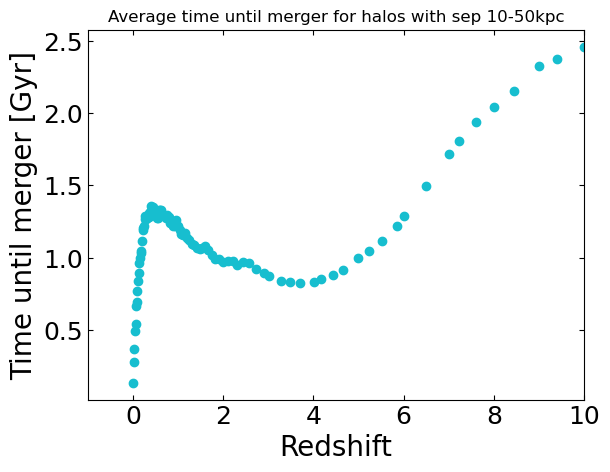

In [330]:
plt.scatter(convert['Redshift'],mean_time_til,color="tab:cyan")
# plt.plot(convert["Redshift"],2/(1+(convert["Redshift"]))**2,label=r"$C(1+z)^{-2}$",color="tab:olive")
plt.title("Average time until merger for halos with sep 10-50kpc",fontsize=12)
plt.xlim(right=10)
plt.xlabel("Redshift")
plt.ylabel("Time until merger [Gyr]")
plt.savefig("../../plots/bet-on-it/3_timeinbin_untilmerger_phys.png")

plt.show()





<font color='red'>could color the points by the fraction of things at that redshift that merge (two plots, one with only the fraction of things in 10-50 selected, and one with the total fraction at any sepeartion that merge, what fraction are within 10-50) 

also figure out where the artificial turn around point happens 




In [351]:
# first do it without the interpolated values & use ONLY the snapshot of interest
# next time do with interp and use some +/- value on either side of the redshift ~ 
mean_time_til_comov, std_time_til_comov = np.zeros((2,len(convert['Snapshot'])))

for i in convert['Snapshot']:
    in_bin = (interp_unique_low["SeparationsComoving"][:,i]<50)&(interp_unique_low["SeparationsComoving"][:,i]>10)&interp_unique_low['MergeFlag']
    
    
    merge_lbt = convert["Lookback Time"][interp_unique_low['MergeSnapshot'][in_bin]]
    time_to_merge = convert['Lookback Time'][i] - merge_lbt
    
    if len(merge_lbt)==0:
        mean_til = np.NaN
        std_til = np.NaN
    else:
        mean_til = np.mean(time_to_merge)
        std_til = np.std(std_in_bin)
    
    mean_time_til_comov[i] = mean_til
    std_time_til_comov[i] = std_til
    #print(mean_in_bin,std_in_bin)
    

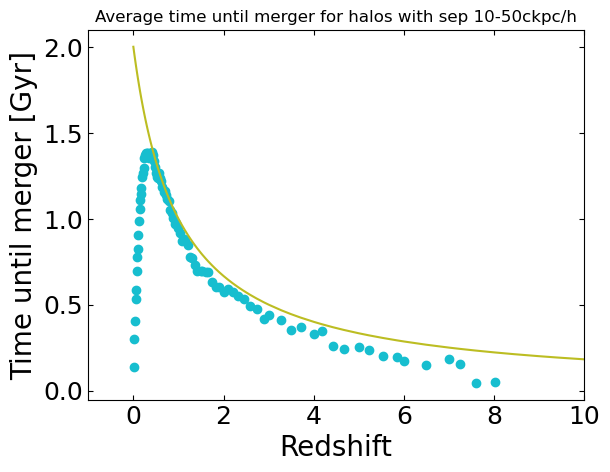

In [368]:
plt.scatter(convert['Redshift'],mean_time_til_comov,color="tab:cyan")
plt.plot(convert["Redshift"],2/(1+(convert["Redshift"]))**1,label=r"$C(1+z)^{-2}$",color="tab:olive")
plt.title("Average time until merger for halos with sep 10-50ckpc/h",fontsize=12)
plt.xlim(right=10)
plt.xlabel("Redshift")
plt.ylabel("Time until merger [Gyr]")
plt.savefig("../../plots/bet-on-it/3_timeinbin_untilmerger_comov.png")

plt.show()





## now to redo the above but using the interpolated data~

In [341]:
upper = 1.5
lower = 1.0
redshift_mask = (interp_convert['Redshift']<upper)&(interp_convert['Redshift']>lower)

(redshift_mask)

10000

In [349]:
np.sum((interp_unique_low['Separations Interp'][:,redshift_mask]>10)&(interp_unique_low['Separations Interp'][:,redshift_mask]<50))
 

2405004

In [ ]:
# first do it without the interpolated values & use ONLY the snapshot of interest
# next time do with interp and use some +/- value on either side of the redshift ~ 
mean_time_til, std_time_til = np.zeros((2,len(convert['Snapshot'])))

for i in convert['Redshift']:
    
    # define upper and lower redshift values to create mask
    if i == convert['Redshift'][0]:
        lower = i
        upper = i + 0.25
    elif i < 0.5:
        lower = i - 0.25
        upper = 0
    else: 
        lower = i - 0.25
        upper = i + 0.25
        
    # make redshift mask 
    redshift_mask = (interp_convert['Redshift']<upper)&(interp_convert['Redshift']>lower)
    
        
    interp_convert['Redshift']
    
    in_bin = (interp_unique_low['Separations Interp'][:,i]<50)&(interp_unique_low['Separations Interp'][:,i]>10)&interp_unique_low['MergeFlag']
    
    
    merge_lbt = convert["Lookback Time"][interp_unique_low['MergeSnapshot'][in_bin]]
    time_to_merge = convert['Lookback Time'][i] - merge_lbt
    
    if 1==0:
        mean_til = np.NaN
        std_til = np.NaN
    else:
        mean_til = np.mean(time_to_merge)
        std_til = np.std(std_in_bin)
    
    mean_time_til[i] = mean_til
    std_time_til[i] = std_til
    #print(mean_in_bin,std_in_bin)
    

## what about the amount of time until merger after the first entry into 10-50kpc bin ? 


In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(10,10),sharey=True, sharex='col', 
                       gridspec_kw={'width_ratios': [1,1], 
                                    'height_ratios':[1,1,1],
                                    'wspace': 0.04,
                                    "hspace":0.0})
z={"33":"z=2","40":"z=1.5","50":"z=1"}
little_h = 0.6774

for en,i in enumerate([low, high]):
    for ii, snap in enumerate([33, 40, 50]):
        orb = i[snap]
        sep_matrix = orb["Separations"]
        elapsed_time = np.abs(np.diff(convert["Lookback Time"]))
        scales = convert['Scale'] # gives scale in same order as orbit data

        scale_matrix = np.tile(scales,(len(sep_matrix),1))
        sep_ckpcperh = sep_matrix/scale_matrix*little_h

        # array of the elapsed time with a nan value in the place of z=0
        elapsed_noz0 = np.concatenate((elapsed_time,np.array([0])))
        elapsed_matrix = np.tile(elapsed_noz0,(len(sep_matrix),1))

        nan_elapsed = np.isnan(elapsed_matrix)
        nan_sep = np.isnan(sep_matrix)
        zero_sep = sep_matrix == 0
        lower_sep = sep_ckpcperh > 10
        matrix_mask = ~nan_elapsed&~nan_sep&~zero_sep&lower_sep

        merger_array = np.array(orb["MergeFlag"],dtype='bool')
        merge_mask = np.tile(merger_array,(100,1)).transpose()

    #     elapsed_masked = elapsed_matrix[matrix_mask]
    #     sep_masked = sep_matrix[matrix_mask]

        ## calculate histograms
        xx_phys = sep_matrix[matrix_mask&merge_mask&orb['GroupFlag']]
        xx_phys_all = sep_matrix[matrix_mask&orb['GroupFlag']]


        xx_comov = sep_ckpcperh[matrix_mask&merge_mask&orb['GroupFlag']]
        xx_comov_all = sep_ckpcperh[matrix_mask&orb['GroupFlag']]

        yy = elapsed_matrix[matrix_mask&merge_mask&orb['GroupFlag']]
        yy_all = elapsed_matrix[matrix_mask&orb['GroupFlag']]

        num_mergers = sum(merger_array)
        num_pairs = len(merger_array) 
        bins_phys = np.arange(0,1000,20)
        bins_ckpch = np.arange(10,1500,20)

        phys, _ = np.histogram(xx_phys,bins=bins_phys,weights=yy/num_mergers)
        phys_all, _ = np.histogram(xx_phys_all,bins=bins_phys,weights=yy_all/num_pairs)
        comov, _ = np.histogram(xx_comov,bins=bins_ckpch,weights=yy/num_mergers)
        comov_all, _ = np.histogram(xx_comov_all,bins=bins_ckpch,weights=yy_all/num_pairs)    

        ax[ii][en].stairs(np.cumsum(phys),bins_phys,color="darkolivegreen",lw=2,alpha=0.15,fill=True,label="Mergers")
        ax[ii][en].stairs(np.cumsum(phys),bins_phys,color="darkolivegreen",lw=2)
        ax[ii][en].stairs(np.cumsum(phys_all),bins_phys,color="mediumturquoise",lw=2,label='All Pairs')

#         ax[ii][1].stairs(np.cumsum(comov),bins_ckpch,color="tab:olive",lw=2,alpha=0.15,fill=True,label="Mergers")
#         ax[ii][1].stairs(np.cumsum(comov),bins_ckpch,color="tab:olive",lw=2)
#         ax[ii][1].stairs(np.cumsum(comov_all),bins_ckpch,color="tab:cyan",lw=2,label='All Pairs')

#         ax[ii][1].text(375,0.1,f"{z[str(snap)]}")


    #     ax[ii].stairs(merged_vals,merged_edges,color="coral",lw=2,alpha=0.15,fill=True)
    #     ax[ii].stairs(merged_vals,merged_edges,color="coral",lw=2,label="Merged")
    #     ax[ii].stairs(all_vals,all_edges,color="tab:cyan",lw=2,label="Group & lower phys sep",)
    # #     ax[ii].stairs(unmerged_vals,unmerged_edges,color="cornflowerblue",lw=2,label="Unmerged")

    #     ax[ii].text(0,1,f"{z[str(snap)]}")
    #     ax[ii].text(230,1.05,f"{(100*num_unmerged/num_pairs):.1f}%",color="cornflowerblue")
    #     ax[ii].text(100,0.2,f"{(100*num_mergers/num_pairs):.1f}%",color="coral")


    ax[0][0].set_title("Low Mass Pairs",fontsize=20)
    ax[0][1].set_title("High Mass Pairs",fontsize=20)

#     ax[2][0].set_xlabel("Separation [kpc]")
#     ax[2][1].set_xlabel("Comoving Separation [ckpc/h]")

#     ax[0][0].legend()
#     ax[0][1].legend()

#     ax[0][0].legend()
#     fig.suptitle("Total time with sep < S: Massive pairs")
    # fig.suptitle("Timescales for major dwarf pairs",y=0.92)
    fig.supxlabel("Separation S [kpc]",y=0.05)
#     fig.supylabel(r"$\left< \Delta T\right>_{pair}$ where $r_{sep}<S$ [Gyr]")
#     plt.savefig(f"{paths.path_plots}big-bad/cumulative-timevssep_z.pdf")
plt.show()


# Graveyard

## How long were things at 10-50 before they merged at this redshift? 

In [226]:
convert['Redshift'][22]

3.7087742646422353

The following plots show the AVERAGE amount of time that a subhalo pair spends with separations 10-50kpc for ONLY THE HALOS that merge at the given snapshot or in the next snapshot. 

For example, the point at z=4 is calculated by picking all pairs that merge at z=4 (snapshot 21) and at z=3.7 (snapshot 22), and taking the average of the total time they are in the 10-50 separation bin

In [312]:
elapsed = np.concatenate((np.abs(np.diff(interp_convert['Lookback Time Interp'])),[0]))
mean_times, std_times = np.zeros((2,len(snapmask)))

for en, i in enumerate(snapmask):
    mergers = np.where(np.isin(interp_unique_low['MergeSnapshot'],i))[0]
    #print('Number of mergers:',len(mergers))
    
    elapsed_in_bin = np.where(interp_unique_low['Separations Interp'][mergers]<50, np.where(interp_unique_low['Separations Interp'][mergers]>10, elapsed, 0), 0)
    if len(elapsed_in_bin)==0:
        mean_in_bin = np.NaN
        std_in_bin = np.NaN
    else:
        mean_in_bin = np.mean(np.sum(elapsed_in_bin,axis=1))
        std_in_bin = np.std(np.sum(elapsed_in_bin,axis=1))
    
    mean_times[en] = mean_in_bin
    std_times[en] = std_in_bin
    #print(mean_in_bin,std_in_bin)
    

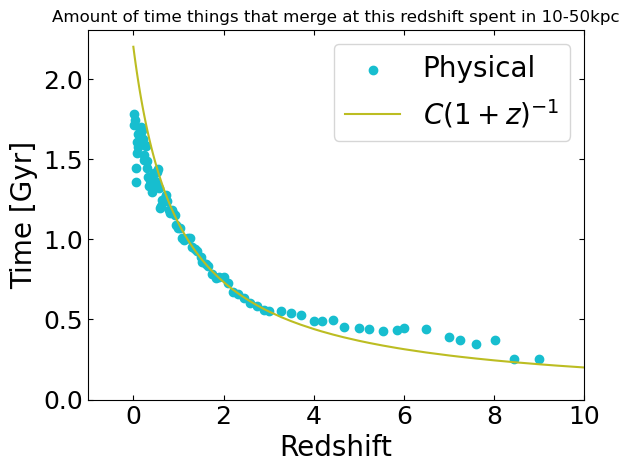

In [324]:
plt.scatter(convert['Redshift'][:-1],mean_times,color="tab:cyan",label='Physical')
plt.plot(convert["Redshift"],2.2/(1+(convert["Redshift"]))**1,label=r"$C(1+z)^{-1}$",color="tab:olive")
plt.xlim(right=10)
plt.title("Amount of time things that merge at this redshift spent in 10-50kpc",fontsize=12)
plt.ylabel("Time [Gyr]")
plt.xlabel('Redshift')
plt.legend()
plt.savefig("../../plots/bet-on-it/3_timeinbin_beforemerger.png")
plt.show()


this is suspiciously the same form as the scale, so let me try with the comoving distances

## Same as above comoving

In [326]:
elapsed = np.concatenate((np.abs(np.diff(interp_convert['Lookback Time Interp'])),[0]))
mean_times_comov, std_times_comov = np.zeros((2,len(snapmask)))

for en, i in enumerate(snapmask):
    mergers = np.where(np.isin(interp_unique_low['MergeSnapshot'],i))[0]
    #print('Number of mergers:',len(mergers))
    
    elapsed_in_bin = np.where(interp_unique_low['SeparationsComoving Interp'][mergers]<50, np.where(interp_unique_low['SeparationsComoving Interp'][mergers]>10, elapsed, 0), 0)
    if len(elapsed_in_bin)==0:
        mean_in_bin = np.NaN
        std_in_bin = np.NaN
    else:
        mean_in_bin = np.mean(np.sum(elapsed_in_bin,axis=1))
        std_in_bin = np.std(np.sum(elapsed_in_bin,axis=1))
    
    mean_times_comov[en] = mean_in_bin
    std_times_comov[en] = std_in_bin
    #print(mean_in_bin,std_in_bin)
    

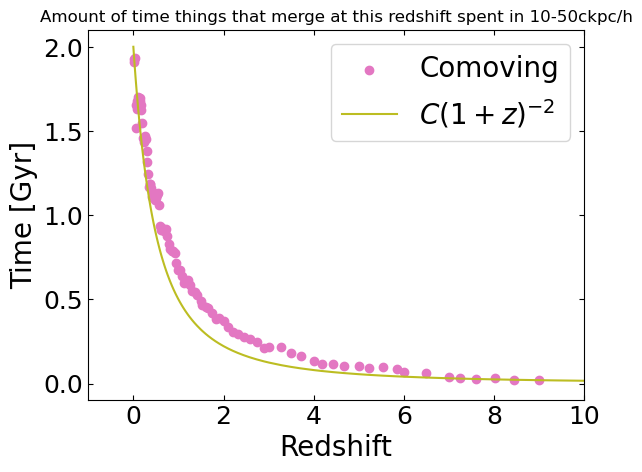

In [329]:

plt.scatter(convert['Redshift'][:-1],mean_times_comov,color="tab:pink",label="Comoving")
plt.plot(convert["Redshift"],2/(1+(convert["Redshift"]))**2,label=r"$C(1+z)^{-2}$",color="tab:olive")
plt.xlim(right=10)
plt.title("Amount of time things that merge at this redshift spent in 10-50ckpc/h",fontsize=12)
plt.ylabel("Time [Gyr]")
plt.xlabel('Redshift')
plt.legend()
plt.savefig("../../plots/bet-on-it/3_timeinbin_beforemerger_comov.png")
plt.show()

